In [2]:
#Se importan librerías a utilizar
library("dplyr")
library("readr")
library("tidyverse")
library("astsa")
library("forecast")

options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ stringr 1.4.0
✔ tidyr   1.1.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas




# Obligatorio - Series Temporales
## Análisis de incendios en Brasil (1998-2017)
### Nicolás Eiris - Ignacio Fiori - Sebastián Otte

In [3]:
#Se lee dataset, y se crea un dataframe, para kuego promediar los estados
df = read_csv(
 "Amazon.csv", 
 col_types = cols(
   month = col_factor(
           levels = c("Janeiro", "Fevereiro",  
                      parse_character("Mar\xe7o", locale = locale(encoding = "ISO-8859-1")), 
                      "Abril", "Maio", "Junho", "Julho", "Agosto", "Setembro", 
                      "Outubro", "Novembro", "Dezembro")), 
   state = col_factor(levels = c("Acre", "Alagoas", "Amapa", 
                                 "Amazonas", "Bahia", "Ceara", 
                                 "Distrito Federal", "Espirito Santo", 
                                 "Goias", "Maranhao", "Mato Grosso", 
                                 "Minas Gerais", 
                                 parse_character("Par\xe1", 
                                                 locale = locale(encoding = "ISO-8859-1")), 
                                 "Paraiba", "Pernambuco", "Piau", "Rio", "Rondonia", 
                                 "Roraima", "Santa Catarina", "Sao Paulo", 
                                 "Sergipe", "Tocantins")),
   date = col_date(format = "%Y-%m-%d"),
   year = col_factor(levels = c("1998", "1999", "2000", "2001", "2002", "2003","2004",
                                "2005", "2006", "2007", "2008","2009", "2010", "2011", 
                                "2012", "2013", "2014", "2015", "2016", "2017"))
   ), 
 locale = locale(encoding = "ISO-8859-1", grouping_mark = "." ))

In [4]:
#Se muestra dataset
head(df)

year,state,month,number,date
<fct>,<fct>,<fct>,<dbl>,<date>
1998,Acre,Janeiro,0,1998-01-01
1999,Acre,Janeiro,0,1999-01-01
2000,Acre,Janeiro,0,2000-01-01
2001,Acre,Janeiro,0,2001-01-01
2002,Acre,Janeiro,0,2002-01-01
2003,Acre,Janeiro,10,2003-01-01


##### Parse date from year & month

In [5]:
parse_date = function(row) {
    year = row["year"]
    month = row["month"]
    month_num = -1
    if (month == "Janeiro") {
        month_num = "01" 
    } else if (month == "Fevereiro") {
        month_num = "02"
    } else if (month == "Março") {
        month_num = "03"
    } else if (month == "Abril") {
        month_num = "04"
    } else if (month == "Maio") {
        month_num = "05"
    } else if (month == "Junho") {
        month_num = "06"
    } else if (month == "Julho") {
        month_num = "07"
    } else if (month == "Agosto") {
        month_num = "08"
    } else if (month == "Setembro") {
        month_num = "09"
    } else if (month == "Outubro") {
        month_num = "10"
    } else if (month == "Novembro") {
        month_num = "11"
    } else if (month == "Dezembro") {
        month_num = "12"
    }
    paste(year, month_num, "01",sep="-")
}
df$date = apply(df, 1, parse_date)
head(df)

year,state,month,number,date
<fct>,<fct>,<fct>,<dbl>,<chr>
1998,Acre,Janeiro,0,1998-01-01
1999,Acre,Janeiro,0,1999-01-01
2000,Acre,Janeiro,0,2000-01-01
2001,Acre,Janeiro,0,2001-01-01
2002,Acre,Janeiro,0,2002-01-01
2003,Acre,Janeiro,10,2003-01-01


#### Keep target & date columns

In [6]:
brasil = df %>%
  group_by(year, month) %>%
  summarise(number = sum(number))

brasil$date = apply(brasil, 1, parse_date)
show(brasil)

`summarise()` regrouping output by 'year' (override with `.groups` argument)



# A tibble: 239 x 4
# Groups:   year [20]
   year  month     number date      
   <fct> <fct>      <dbl> <chr>     
 1 1998  Janeiro        0 1998-01-01
 2 1998  Fevereiro      0 1998-02-01
 3 1998  Março          0 1998-03-01
 4 1998  Abril          0 1998-04-01
 5 1998  Maio           0 1998-05-01
 6 1998  Junho       3551 1998-06-01
 7 1998  Julho       8066 1998-07-01
 8 1998  Agosto     35549 1998-08-01
 9 1998  Setembro   41968 1998-09-01
10 1998  Outubro    23495 1998-10-01
# … with 229 more rows


In [7]:
brasil = brasil[, c("date", "number")]

In [8]:
brasil <- brasil[order(brasil$date),]

In [9]:
#Se genera serie temporal con los datos desde Junio 1998 a Diciembre 2017
brasil_ts <- ts(brasil$number, 
            start=c(1998, 1), 
            end=c(2017, 11),
            frequency = 12)

brasil_ts <- ts(tail(brasil_ts,-5), 
            start=c(1998, 6), 
            end=c(2017, 11),
            frequency = 12)
show(brasil_ts)

        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
1998                                      3551   8066  35549  41968  23495
1999   1081   1284    667    717   1812   3632   8756  38415  36913  27012
2000    778    561    848    537   2097   6275   4739  22202  22319  24321
2001    547   1059   1268   1081   2090   8433   6490  31887  32193  31038
2002   1654   1570   1679   1682   3818  10839  13751  55099  49566  47722
2003   5091   2398   2749   2677   1747   6506  11804  37382  55913  43295
2004   2705   1255   2040   1335   3535  14262  23809  48038  70531  36002
2005   4990   2153   1706   1011   3210   5811  15663  39912  74574  49876
2006   3255   1666   1774    792    808   1968   5722  29443  41264  21854
2007   3055   1751   2136    415   1286   3956   6197  66837  78299  27911
2008   2125   1275   1239   1253    553   1287   4507  14528  35836  37617
2009   2848   1140   1392   1078   2593   2962   6599  15534  25002  24202
2010   2851   2386   2417

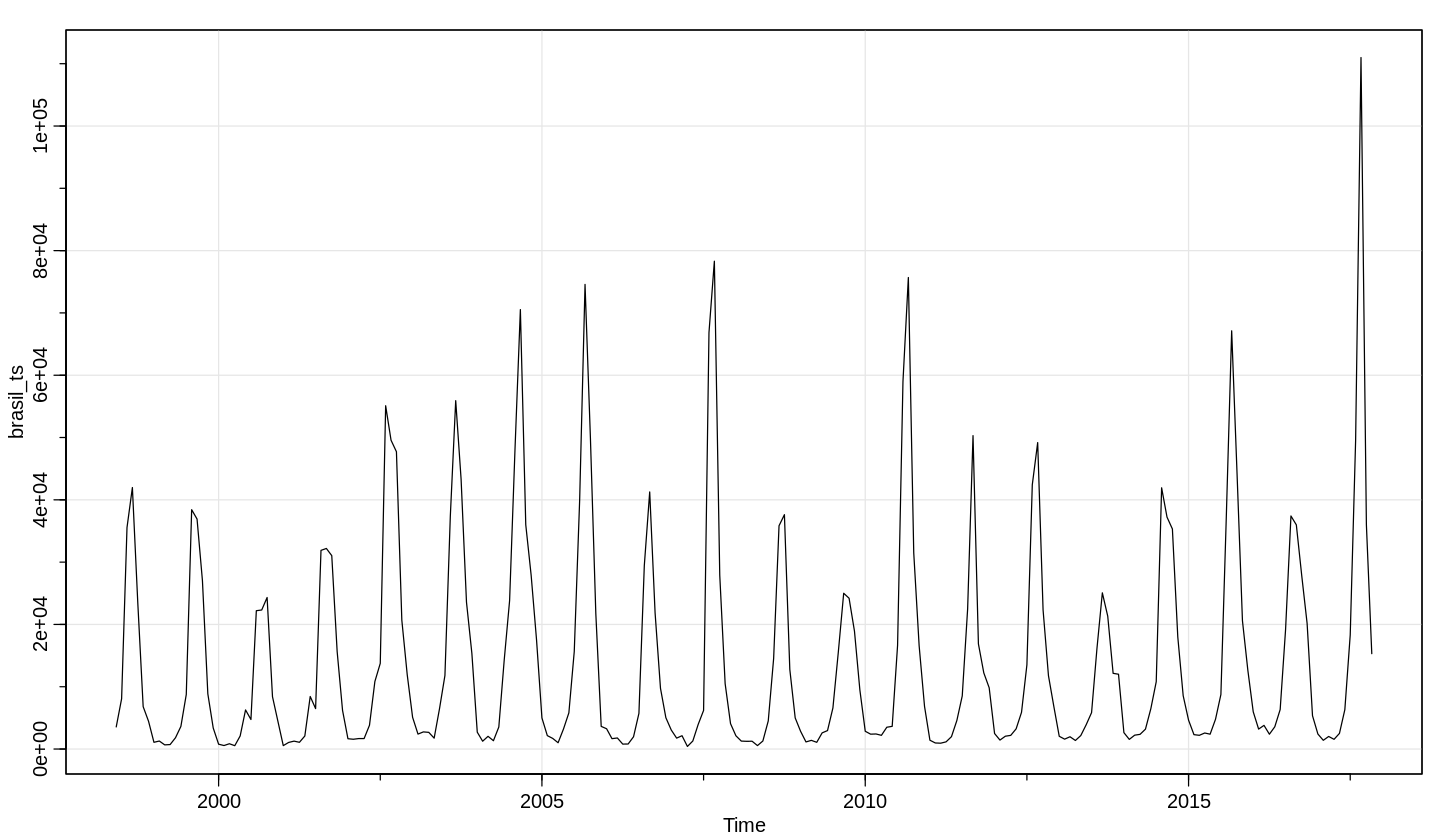

In [10]:
#Se realiza plot inicial de la serie a analizar
tsplot(brasil_ts)

## Estacionalidad de la serie temporal

Esta serie parece ser estacionaria?

- No parece ser estacionaria ya que los tiempos de los picos superiores son mucho menores que los picos inferiores(se mantienen más en el tiempo) lo que habla de una varianza no constante.

En busca de una serie estacionaria un primer paso sería eliminar el crecimiento de la señal. Se observa una periodicidad anual en la serie y también se puede afirmar en primera instancia que no existe un crecimiento a lo largo del tiempo que lleve a aplicar `diff` sobre la serie temporal.

Lo que si se puede realizar como primer paso es aplicar `log` a los valores de la serie ya que presenta fluctuaciones considerables en los valores. Por tanto procedemos a aplicar esta operación y observar la serie resultante.

Como los primeros 5 valores son 0 (`log(0)= -Inf`) tomamos la decisión de sustituirlos por la media de la serie excluyendo estos primeros 5 valores.

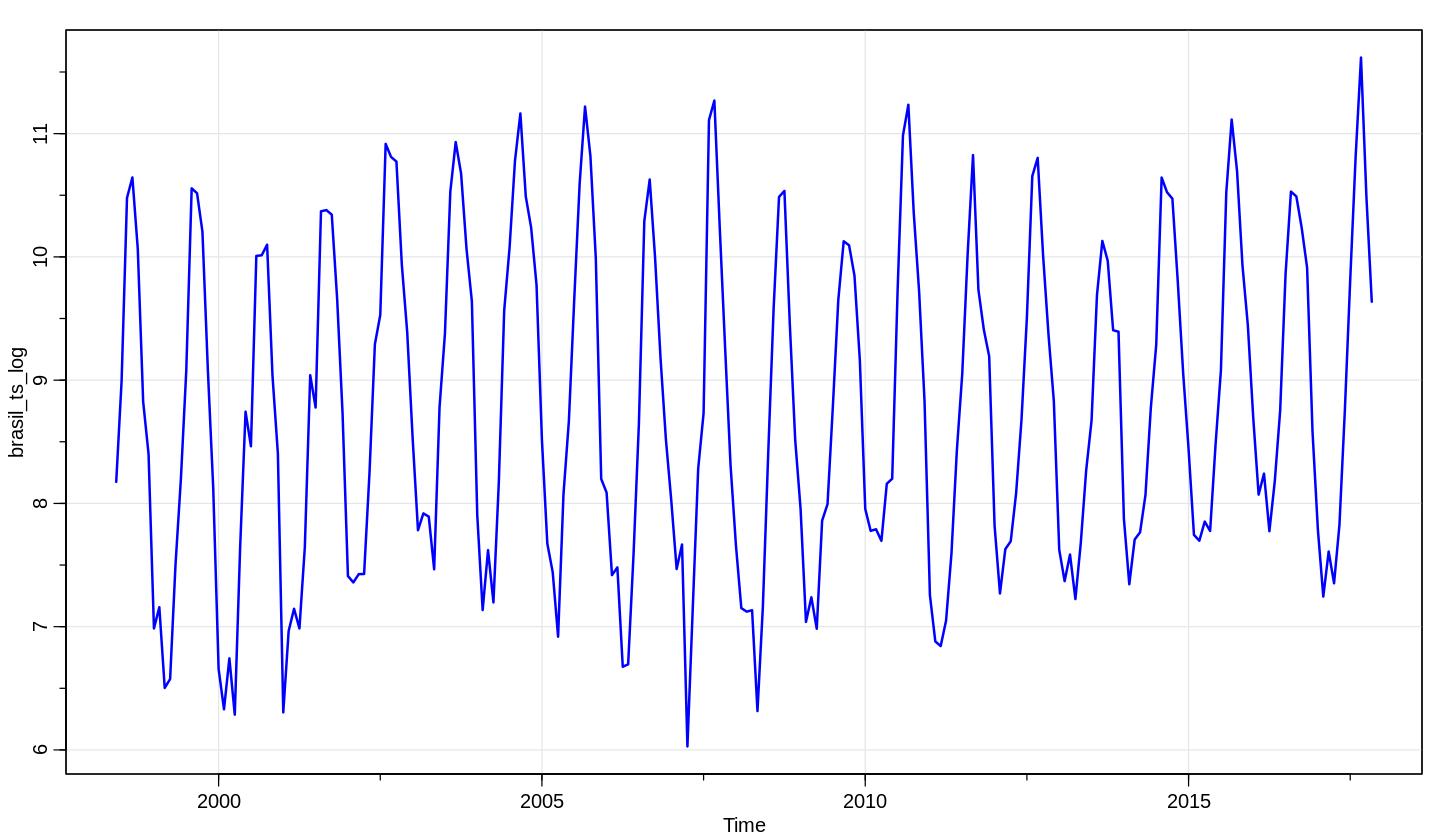

In [11]:
#Se aplica logaritmo sobre la serie original
brasil_ts_log = log(brasil_ts)
tsplot(brasil_ts_log, col=4, lwd=2)

El resultado de la operación `log` sobre la serie parece dar muy buenos resultados ya que nuestro objetivo es trabajar a partir de una serie estacionaria y vemos que la misma presenta todas las características de estacioneidad. Tanto la media como la varianza muestran signos de ser constantes a lo largo del tiempo.

Dada esta afirmación, lo único que resta es quitar una posible tendencia y poder obtener la señal centrada en 0, y asi poder comenzar el análisis desde este punto.


Call:
lm(formula = brasil_ts_log ~ t)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7317 -1.1594 -0.1631  1.1575  2.6294 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -35.14087   30.94320  -1.136    0.257
t             0.02187    0.01541   1.419    0.157

Residual standard error: 1.327 on 232 degrees of freedom
Multiple R-squared:  0.008609,	Adjusted R-squared:  0.004336 
F-statistic: 2.015 on 1 and 232 DF,  p-value: 0.1571


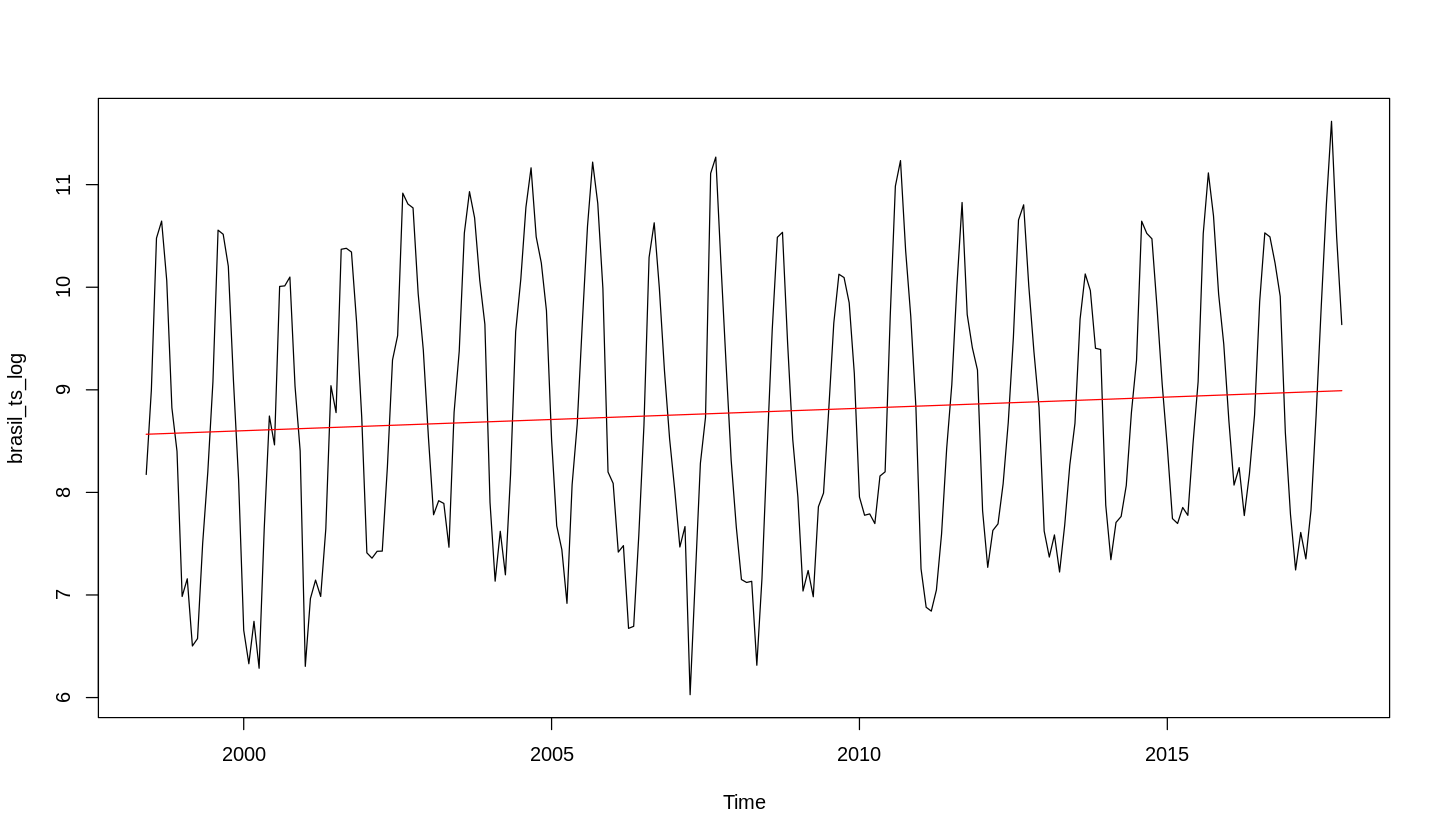

In [12]:
#Se hace ajuste por tendencia solamente
t = time(brasil_ts_log)
fit_lm1 = lm(brasil_ts_log~t)
pred_fit_lm1 = ts(predict(fit_lm1), start=c(1998, 6), frequency = 12)

#ploteamos señal y predicción
plot(brasil_ts_log)
lines(pred_fit_lm1, col=2)

summary(fit_lm1)

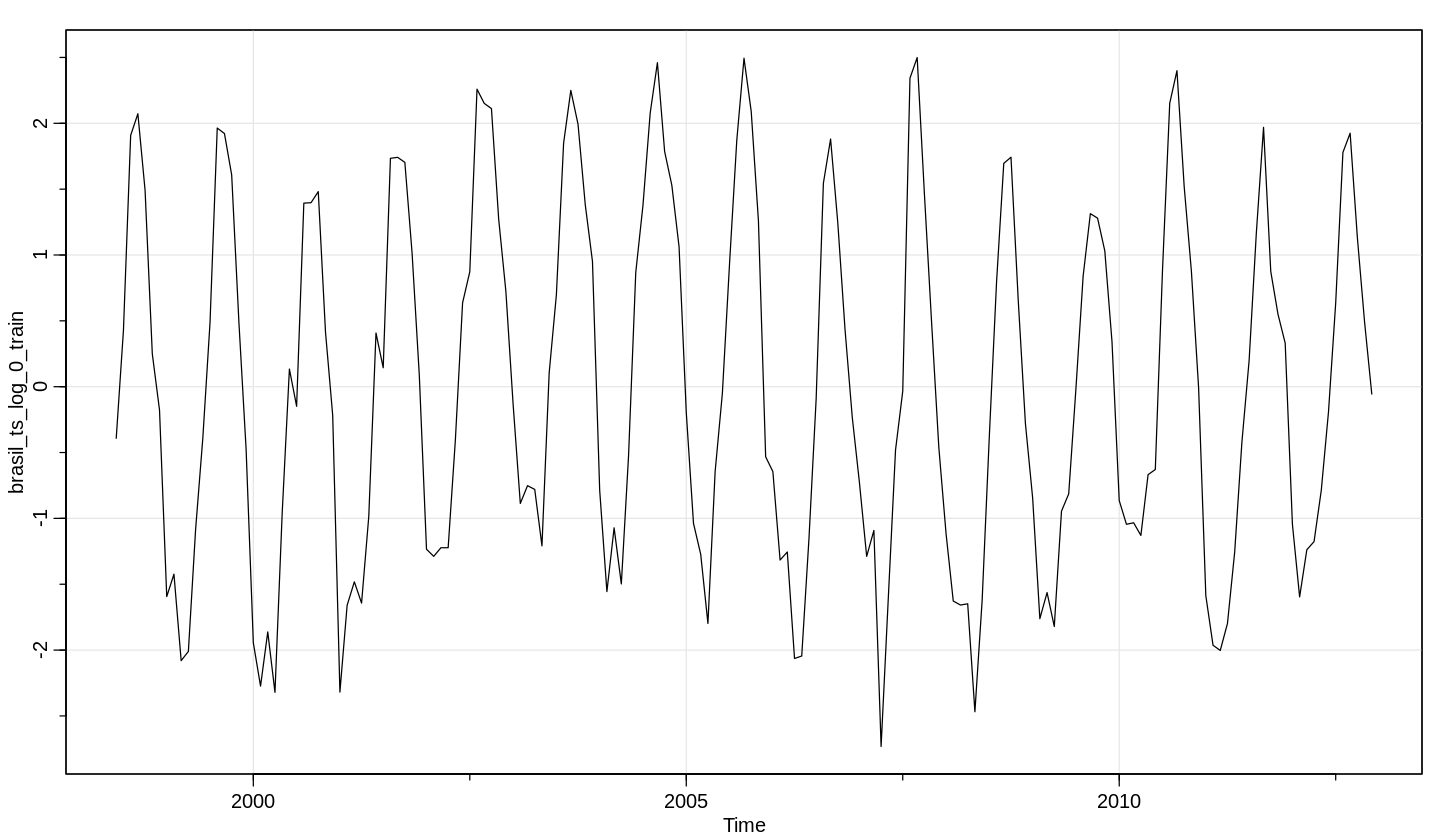

In [13]:
#Nuestra serie sin tendencia y centrada en 0 la obtenemos como los residuos del ajuste lineal anterior
brasil_ts_log_0 = ts(residuals(fit_lm1), start=c(1998, 6), frequency = 12)

#Separamos dataset en train y test
brasil_ts_log_0_train <- ts(brasil_ts_log_0[1:175], 
            start=c(1998, 6), 
            end=c(2012, 12),
            frequency = 12)
brasil_ts_log_0_test <- ts(brasil_ts_log_0[176:length(brasil_ts_log_0)], 
            start=c(2013, 1), 
            end=c(2017, 11),
            frequency = 12)
tsplot(brasil_ts_log_0_train)

## Análisis de la serie temporal estacionaria

Como primeros pasos del análisis interesa:

- Estudiar la varianza (acf & pacf)
- Tener una noción del orden de la serie (periodograma)

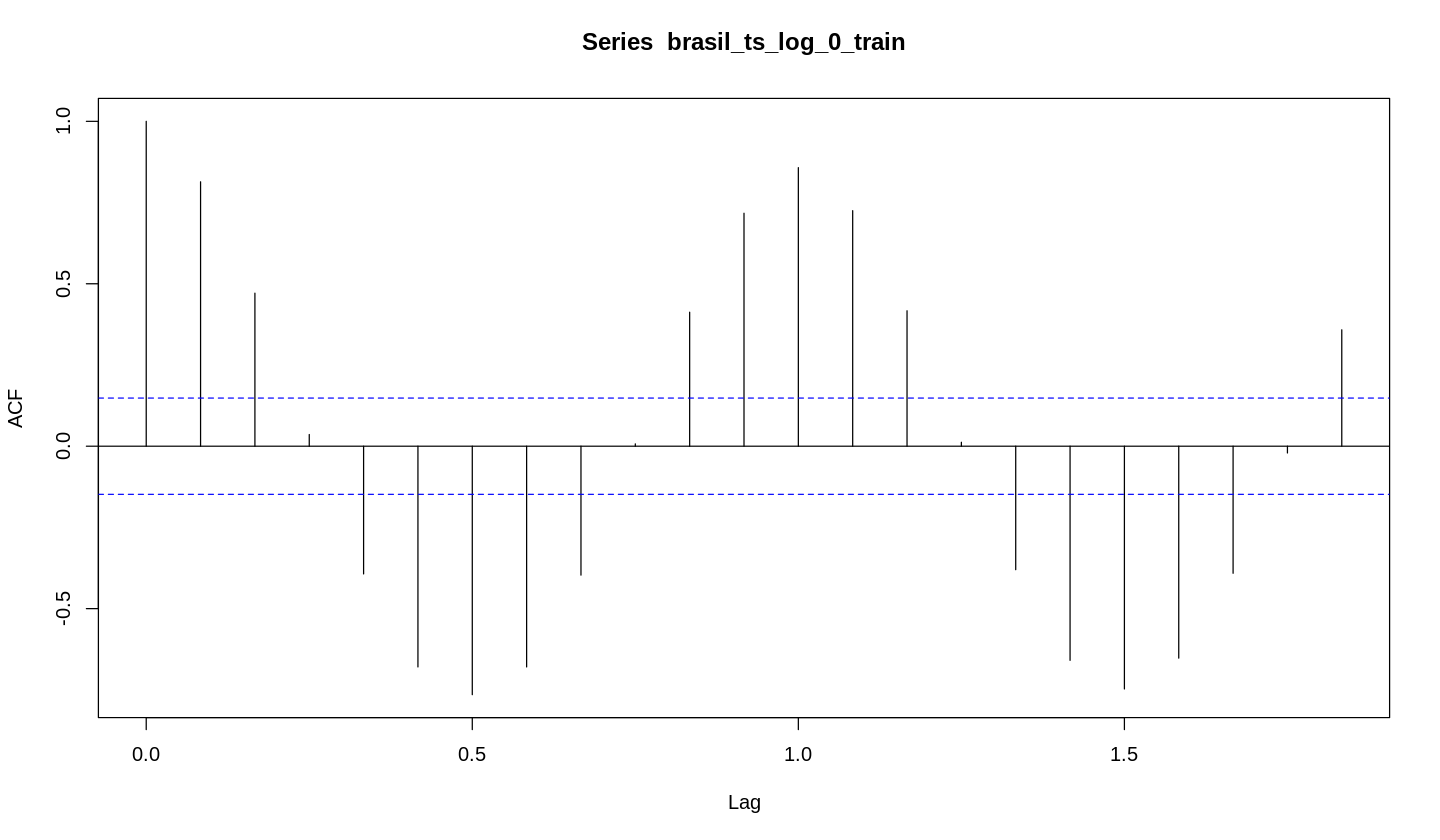

In [14]:
acf(brasil_ts_log_0_train)

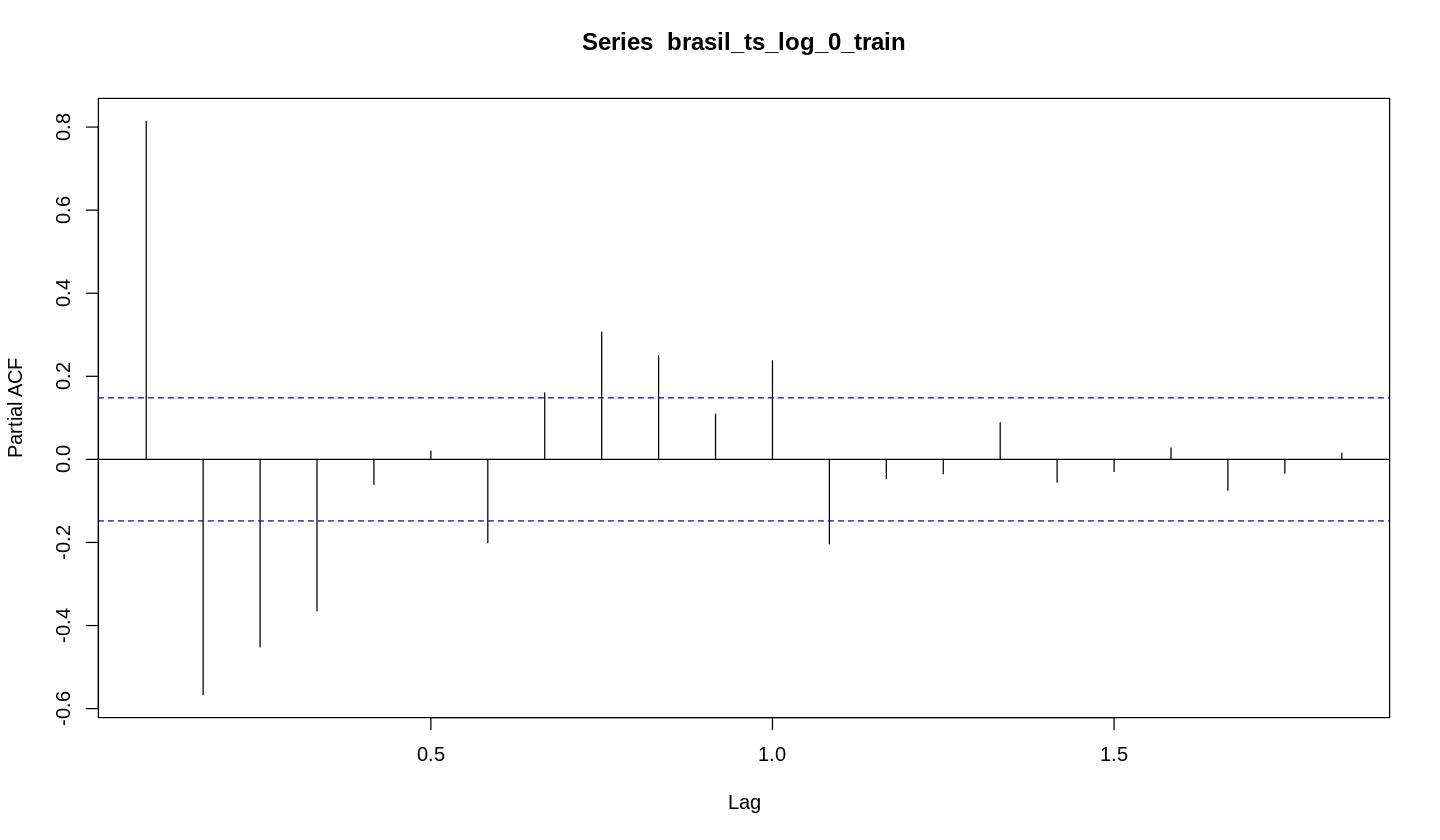

In [15]:
pacf(brasil_ts_log_0_train)

Tanto el `acf` como el `pacf` no aportan información relevante acerca de la serie. Por lo que calcularemos el periodograma y en base a eso evaluar ajustar un modelo lineal con las frecuencias estimadas con el periodograma.

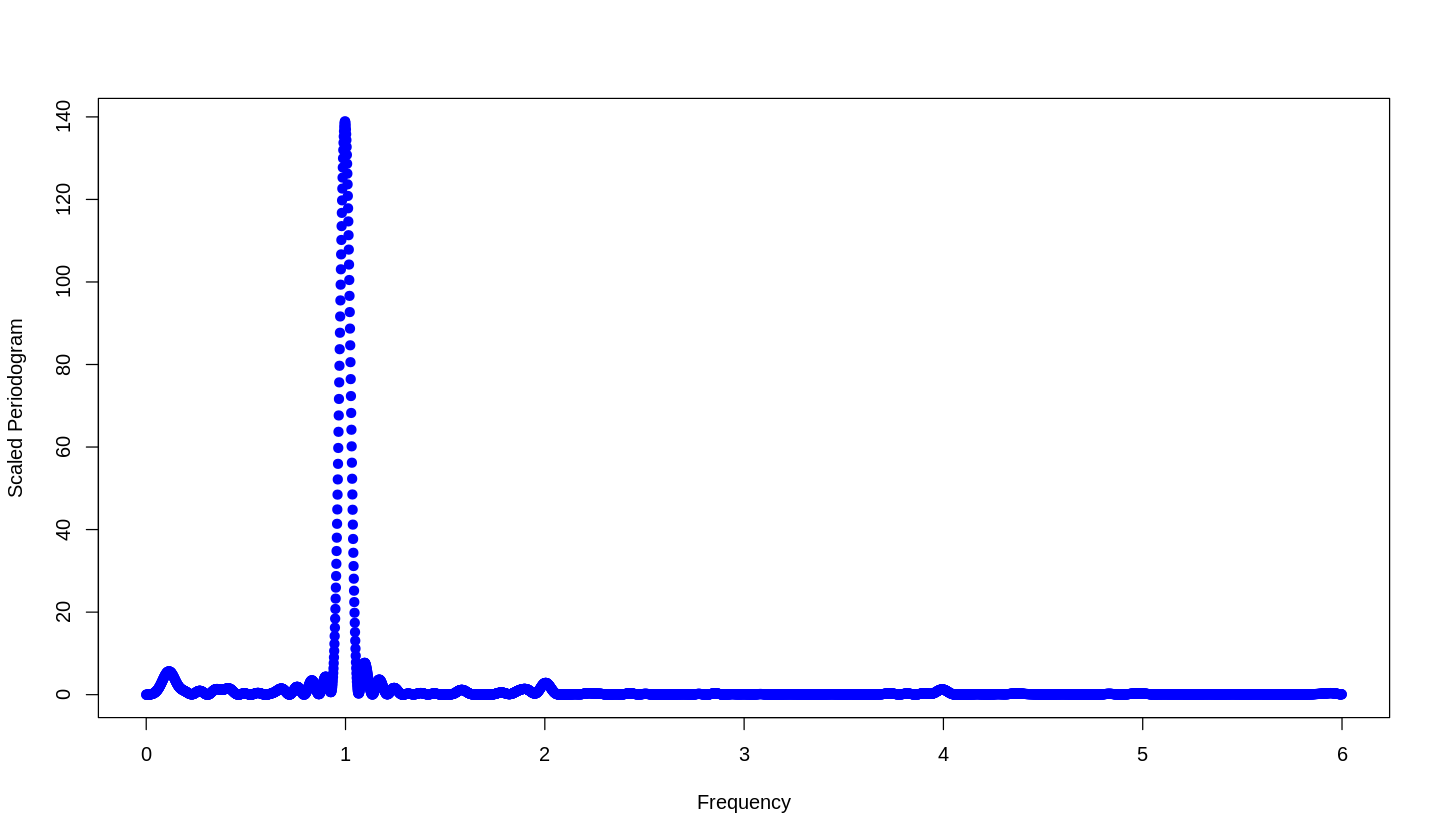

In [16]:
#Periodograma
n = length(brasil_ts_log_0_train)


xzp = c(brasil_ts_log_0_train,rep(0,10000-n))

Nzp = length(xzp)

xPerZp = (1/n)*abs(fft(xzp)^2)
xPerZp = xPerZp[1:floor(Nzp/2)]


fzp = (0:(Nzp/2-1))/Nzp*12

plot(fzp,xPerZp,  type="b", xlab="Frequency", ylab="Scaled Periodogram", col=4, lwd=1, pch=19)

In [17]:
#Armamos periodograma y elegimos las frecuencias mas significativas
periodograma=data.frame(fzp, xPerZp,options(scipen = 999))
#show(periodograma)

#Se eligen las 2 frecuencias más características del periodograma ~1 y una baja frecuencia
f1=0.9972
f2=0.1140


Del periodograma se puede observar una componente anual bien definida lo que creemos conlleva a un ajuste lineal del estilo:

` model = [a1 * sin(2 * pi * 1) * t] + [a2 * cos(2 * pi * 1) * t]`

Donde debería ajustar tanto `a1` como `a2` utilizando la frecuencia obtenida del periodograma.

In [20]:
t = time(brasil_ts_log_0_train)
fit_brasil_ts_log_0_train_f1 = lm(brasil_ts_log_0_train ~ 0 + sin(2 * pi * (f1) * t) + cos(2 * pi * (f1) * t) )
summary(fit_brasil_ts_log_0_train_f1)


Call:
lm(formula = brasil_ts_log_0_train ~ 0 + sin(2 * pi * (f1) * 
    t) + cos(2 * pi * (f1) * t))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.41391 -0.41188 -0.01382  0.35931  1.03481 

Coefficients:
                       Estimate Std. Error t value            Pr(>|t|)    
sin(2 * pi * (f1) * t)  0.68614    0.05559   12.34 <0.0000000000000002 ***
cos(2 * pi * (f1) * t)  1.65038    0.05573   29.61 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5207 on 173 degrees of freedom
Multiple R-squared:  0.856,	Adjusted R-squared:  0.8543 
F-statistic:   514 on 2 and 173 DF,  p-value: < 0.00000000000000022


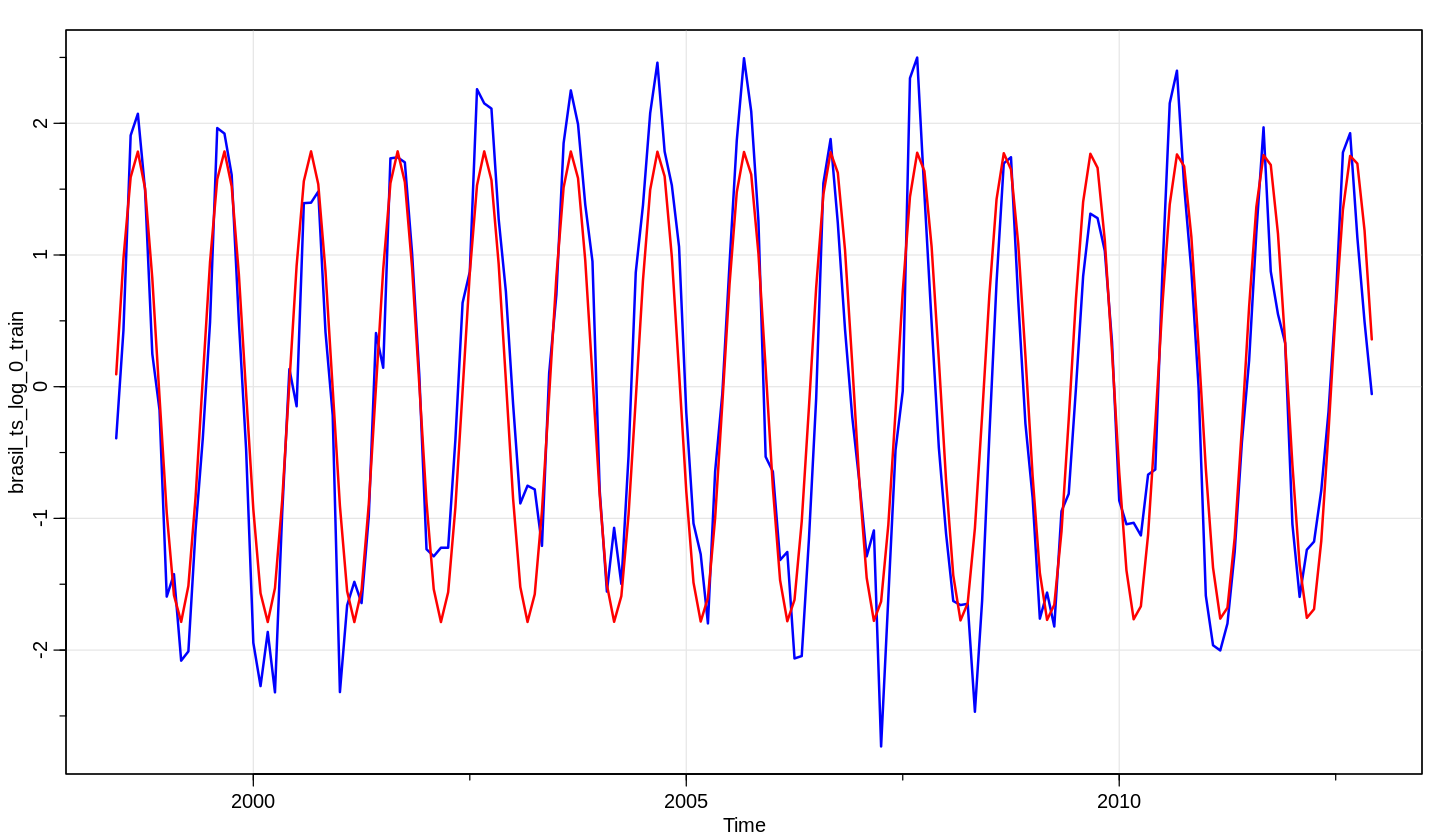

In [21]:
brasil_ts_log_0_train_f1 = ts(fitted(fit_brasil_ts_log_0_train_f1), start=1998+5/12, frequency=12)
tsplot(brasil_ts_log_0_train, col=4, lwd=2)
lines(brasil_ts_log_0_train_f1, col=2, lwd=2)

Podemos observar que hace faltan componente/s de baja frecuencia para ajustar aún mejor la señal estudiada.

In [22]:
#Se toman las frecuancias más significativas de nuestra serie: f1 y f2
t = time(brasil_ts_log_0_train)
fit_brasil_ts_log_0_train_f1_f2 = lm(brasil_ts_log_0_train ~ 0 + sin(2 * pi * (f1) * t) + cos(2 * pi * (f1) * t) + sin(2 * pi * (f2) * t) + cos(2 * pi * (f2) * t) )
summary(fit_brasil_ts_log_0_train_f1_f2)


Call:
lm(formula = brasil_ts_log_0_train ~ 0 + sin(2 * pi * (f1) * 
    t) + cos(2 * pi * (f1) * t) + sin(2 * pi * (f2) * t) + cos(2 * 
    pi * (f2) * t))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22639 -0.30277  0.06168  0.28371  1.16800 

Coefficients:
                       Estimate Std. Error t value             Pr(>|t|)    
sin(2 * pi * (f1) * t)  0.68448    0.04977  13.752 < 0.0000000000000002 ***
cos(2 * pi * (f1) * t)  1.64798    0.04991  33.022 < 0.0000000000000002 ***
sin(2 * pi * (f2) * t)  0.07590    0.05054   1.502                0.135    
cos(2 * pi * (f2) * t) -0.31590    0.04947  -6.386        0.00000000155 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4662 on 171 degrees of freedom
Multiple R-squared:  0.8859,	Adjusted R-squared:  0.8832 
F-statistic: 331.8 on 4 and 171 DF,  p-value: < 0.00000000000000022


Vemos que la componente de seno de f2 parece no ser relevante, y es por lo tanto que decidimos eliminarla y volver a repetir el ajuste

In [23]:
#Se toman las frecuancias más significativas de nuestra serie: f1 y f2
t = time(brasil_ts_log_0_train)
fit_brasil_ts_log_0_train_f1_f2 = lm(brasil_ts_log_0_train ~ 0 + sin(2 * pi * (f1) * t) + cos(2 * pi * (f1) * t) + cos(2 * pi * (f2) * t) )
summary(fit_brasil_ts_log_0_train_f1_f2)


Call:
lm(formula = brasil_ts_log_0_train ~ 0 + sin(2 * pi * (f1) * 
    t) + cos(2 * pi * (f1) * t) + cos(2 * pi * (f2) * t))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.17299 -0.29949  0.07156  0.29845  1.11599 

Coefficients:
                       Estimate Std. Error t value             Pr(>|t|)    
sin(2 * pi * (f1) * t)  0.68416    0.04996  13.695 < 0.0000000000000002 ***
cos(2 * pi * (f1) * t)  1.64666    0.05008  32.881 < 0.0000000000000002 ***
cos(2 * pi * (f2) * t) -0.32178    0.04949  -6.501       0.000000000831 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4678 on 172 degrees of freedom
Multiple R-squared:  0.8844,	Adjusted R-squared:  0.8824 
F-statistic: 438.5 on 3 and 172 DF,  p-value: < 0.00000000000000022


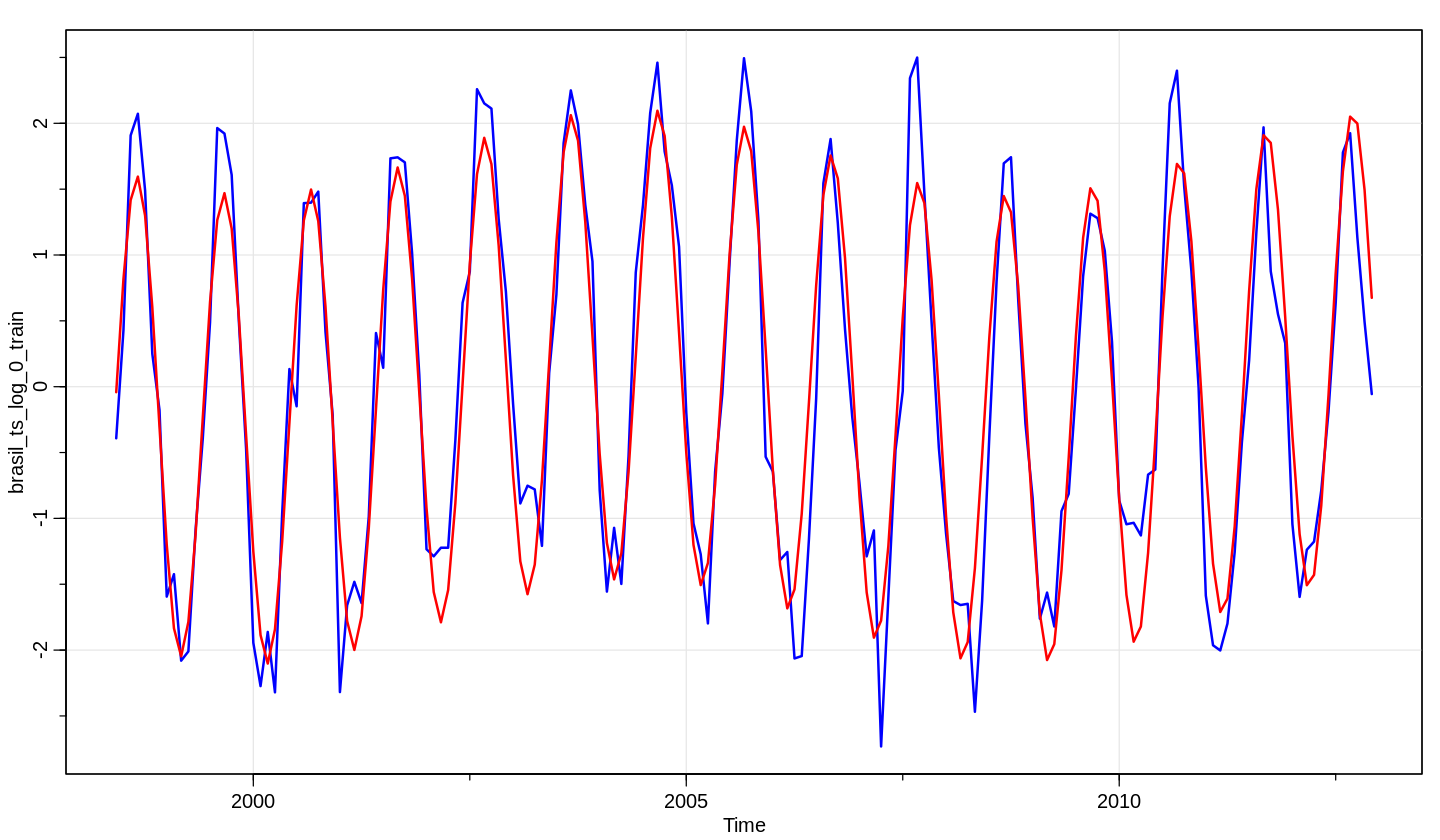

In [24]:
#Se muestra el ajuste mediante f1 y f2
brasil_ts_log_0_train_f1_f2 = ts(fitted(fit_brasil_ts_log_0_train_f1_f2), start=1998+5/12, frequency=12)
tsplot(brasil_ts_log_0_train, col=4, lwd=2)
lines(brasil_ts_log_0_train_f1_f2, col=2, lwd=2)

Con esto concluimos nuestro análisis de estacionalidad por frecuencia y continuaremos el análisis con los residuos de este ajuste que es donde está la información importante de nuestra serie

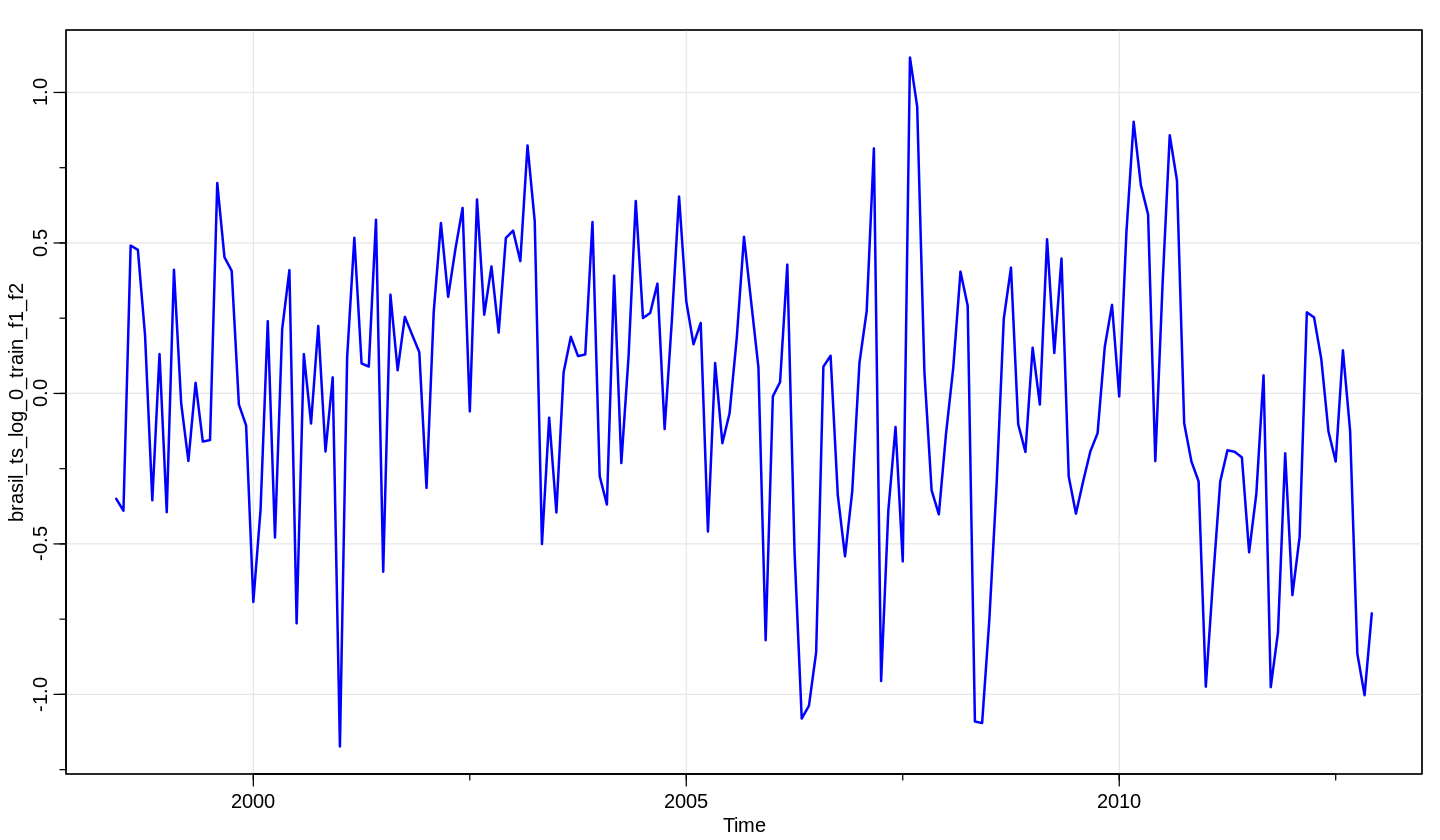

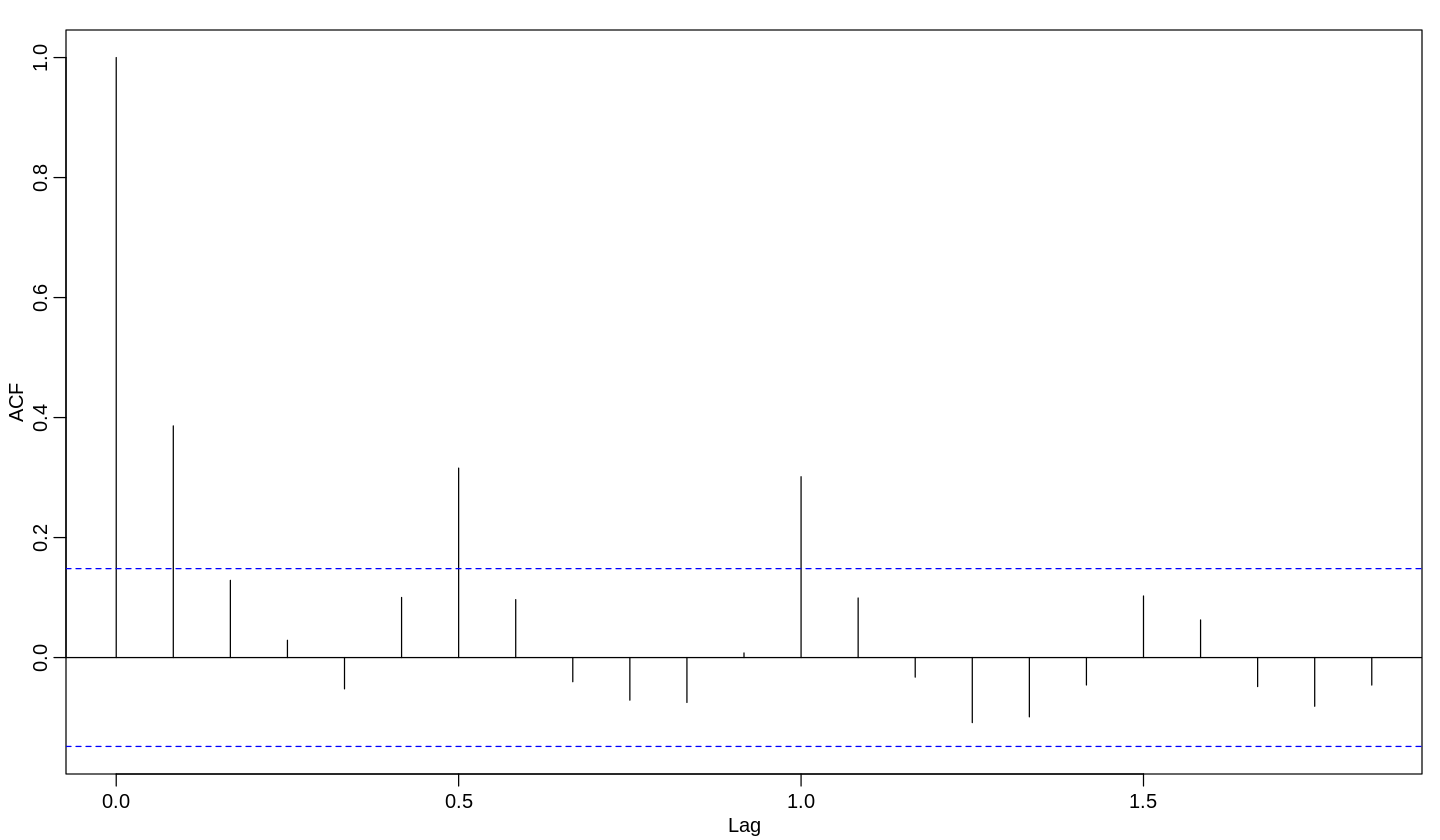

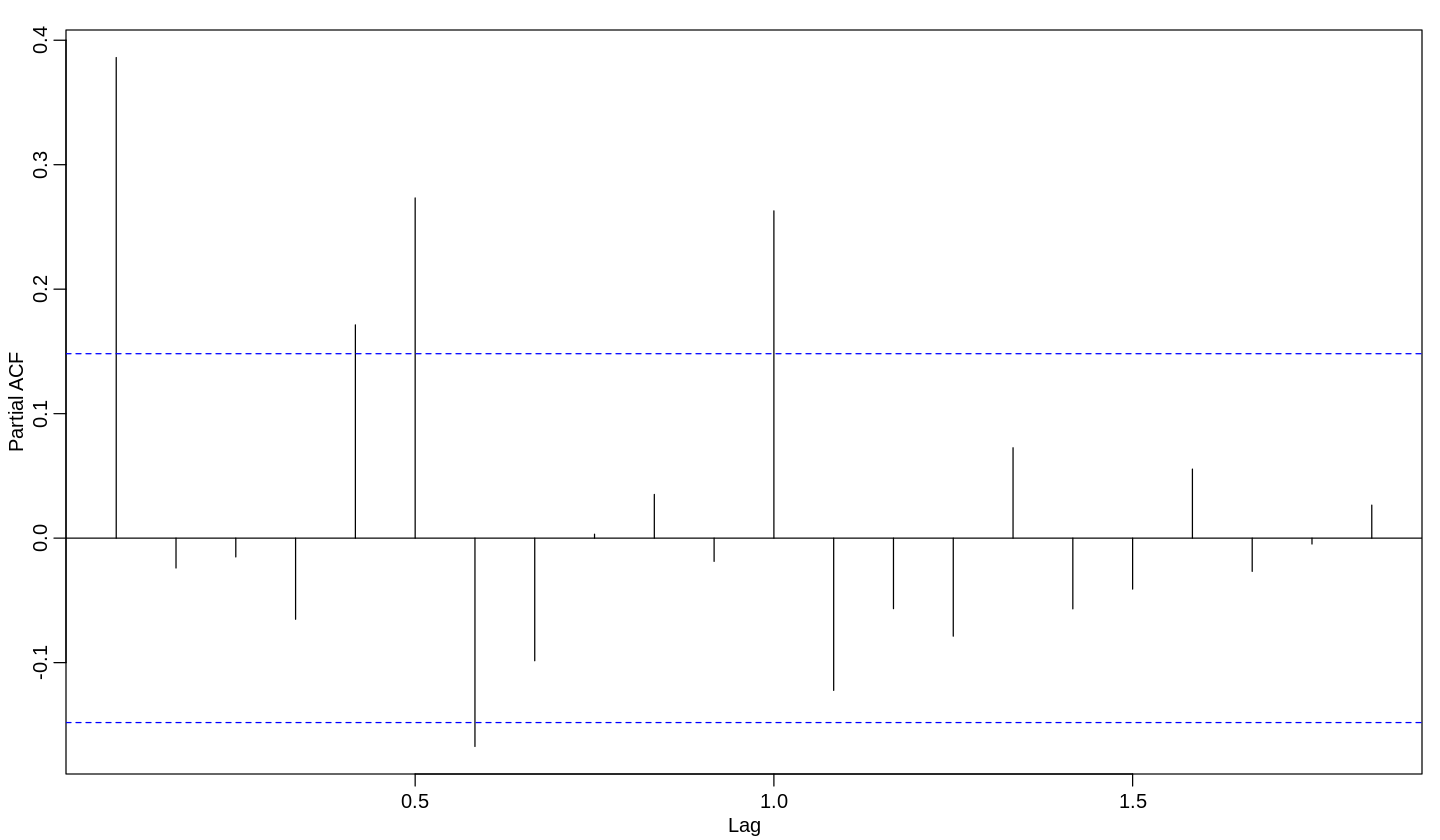

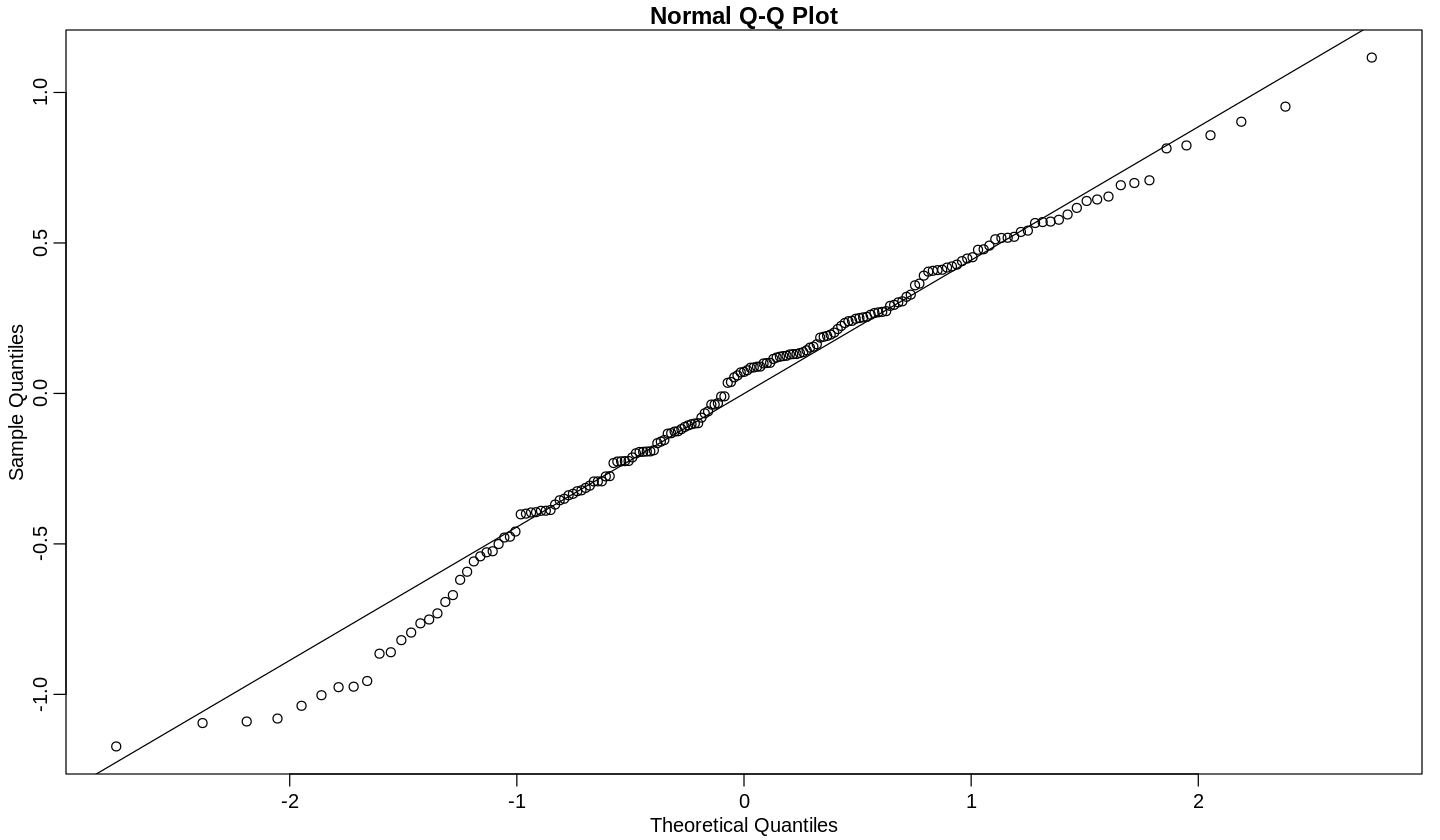

In [25]:
#Ploteamos los residuis para nuestro ajuste fit
brasil_ts_log_0_train_f1_f2 = ts(residuals(fit_brasil_ts_log_0_train_f1_f2), start=1998+5/12, frequency=12)
tsplot(brasil_ts_log_0_train_f1_f2, col=4, lwd=2)

#Analizamos si es ruido blanco
acf(brasil_ts_log_0_train_f1_f2)
pacf(brasil_ts_log_0_train_f1_f2)
qqnorm(brasil_ts_log_0_train_f1_f2)
qqline(brasil_ts_log_0_train_f1_f2)

En base al ajuste y observando la gráfica, podemos afimar que este segundo ajuste, a pesar de ser mas específico tiene mejores resultados que el inicial. 
A continuación analizaremos la estacionalidad de la serie para ver si genera un modelo mas simple que el propuesto hasta el momento.

In [26]:
season_brasil =factor(cycle(brasil_ts_log_0_train))
t=time(brasil_ts_log_0_train)-1998 + 5/12
fit_brasil_ts_log_0_train_season = lm(brasil_ts_log_0_train ~ 0 + t + season_brasil)

summary(fit_brasil_ts_log_0_train_season)


Call:
lm(formula = brasil_ts_log_0_train ~ 0 + t + season_brasil)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.33397 -0.30716 -0.00552  0.35549  1.12597 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
t               -0.008399   0.008811  -0.953               0.3419    
season_brasil1  -1.007270   0.148464  -6.785 0.000000000207726777 ***
season_brasil2  -1.413009   0.148810  -9.495 < 0.0000000000000002 ***
season_brasil3  -1.331070   0.149159  -8.924 0.000000000000000927 ***
season_brasil4  -1.620002   0.149511 -10.835 < 0.0000000000000002 ***
season_brasil5  -1.044027   0.149866  -6.966 0.000000000077420580 ***
season_brasil6  -0.201216   0.144203  -1.395               0.1648    
season_brasil7   0.466805   0.144556   3.229               0.0015 ** 
season_brasil8   1.778909   0.144911  12.276 < 0.0000000000000002 ***
season_brasil9   2.079394   0.145270  14.314 < 0.0000000000000002 ***
season_brasil10  1.636871   0.145631  11.240

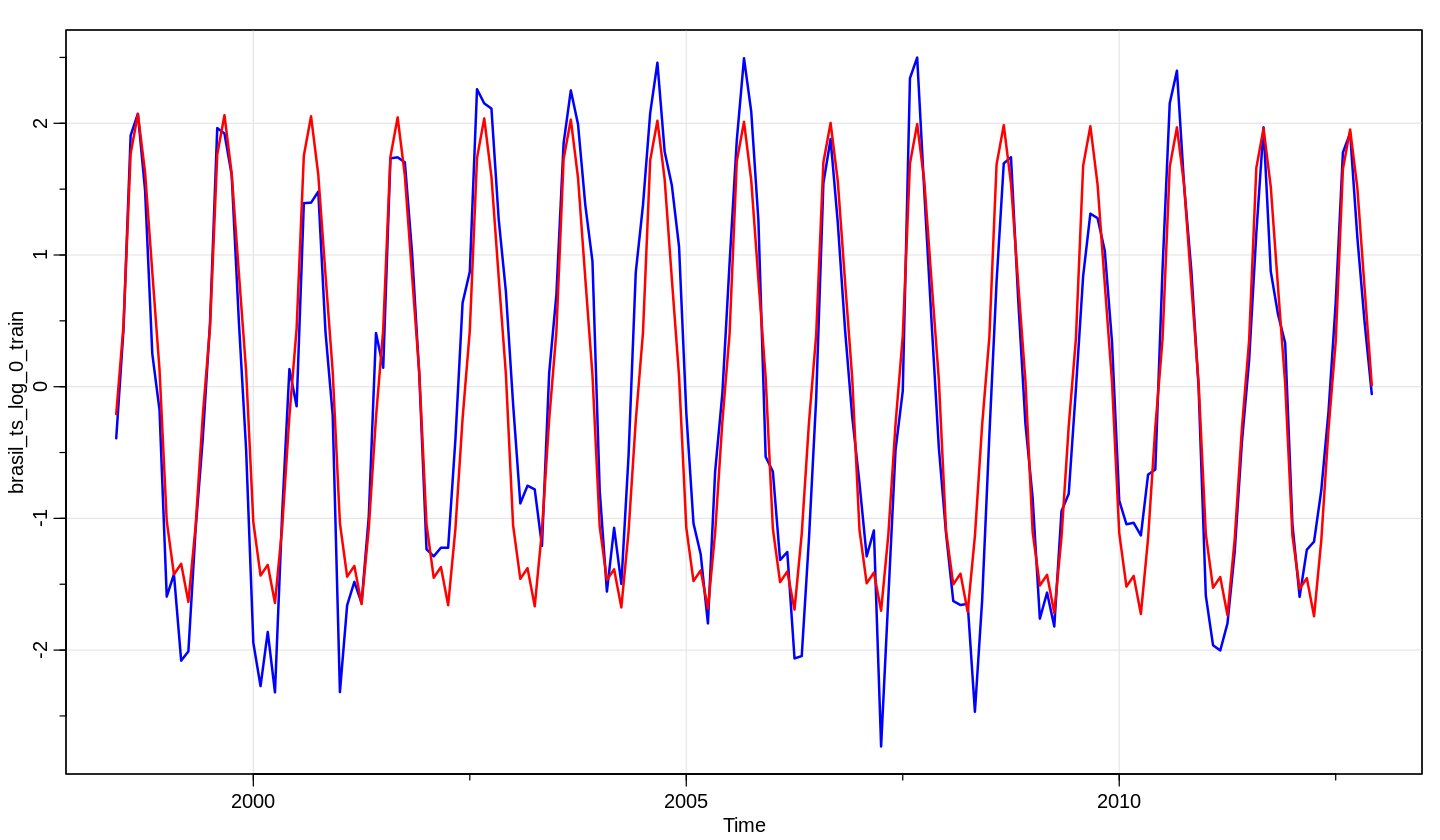

In [27]:
#Se muestra el ajuste mediante seasons
brasil_ts_log_0_train_season = ts(fitted(fit_brasil_ts_log_0_train_season), start=1998+5/12, frequency=12)
tsplot(brasil_ts_log_0_train, col=4, lwd=2)
lines(brasil_ts_log_0_train_season, col=2, lwd=2)

Al observar los resultados, vemos que la mayoría de los términos son significativos lo que va a generar un modelo complejo, además de esto el ajuste no es tan bueno como el del f1 f2, aplicandola ley de ockham nos inclinamos por el modelo basado en  frecuencia ya que contiene menor cantidad de términos y mejores resultados.

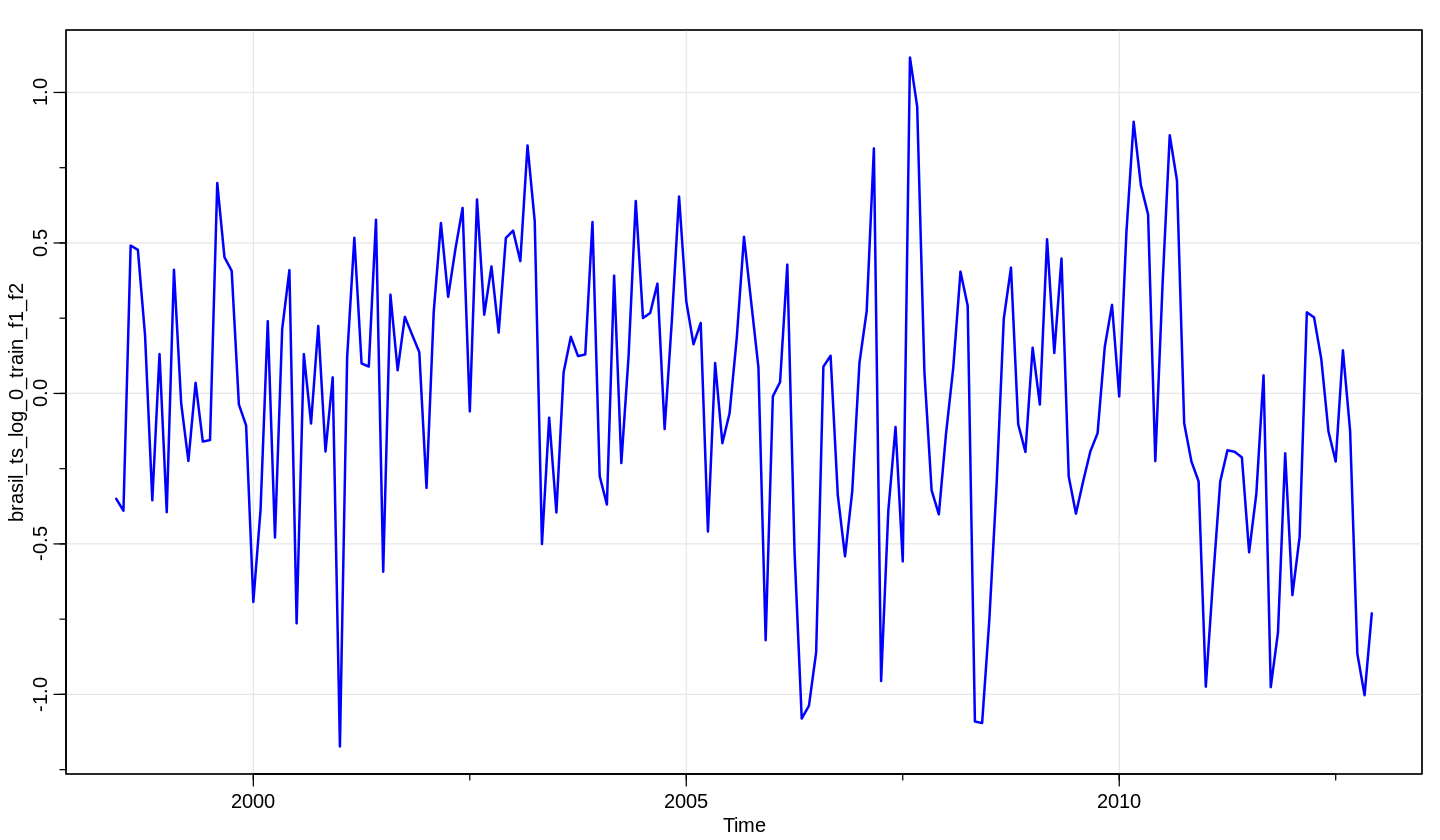

In [41]:
#Llegdo este punto la serie a analifar serán los residuos del ajuste por frecuencias f1 f2
tsplot(brasil_ts_log_0_train_f1_f2, col=4, lwd=2)

#De aqui en adelante por practicidad lo llamaremos brasil clean 
brasil_clean=brasil_ts_log_0_train_f1_f2


### Probamos ajuste de residuos mediente AR(1) y ARMA(1,1) 

In [36]:
fit_AR1_brasil_clean = Arima(brasil_clean,order=c(1,0,0), include.mean=FALSE, include.drift = FALSE)
fit_AR2_brasil_clean = Arima(brasil_clean,order=c(2,0,0), include.mean=FALSE, include.drift = FALSE)
fit_AR3_brasil_clean = Arima(brasil_clean,order=c(3,0,0), include.mean=FALSE, include.drift = FALSE)

fit_MA1_brasil_clean = Arima(brasil_clean,order=c(0,0,1), include.mean=FALSE, include.drift = FALSE)
fit_MA2_brasil_clean = Arima(brasil_clean,order=c(0,0,2), include.mean=FALSE, include.drift = FALSE)
fit_MA3_brasil_clean = Arima(brasil_clean,order=c(0,0,3), include.mean=FALSE, include.drift = FALSE)

fit_ARMA11_brasil_clean = Arima(brasil_clean,order=c(1,0,1), include.mean=FALSE, include.drift = FALSE)
fit_ARMA12_brasil_clean = Arima(brasil_clean,order=c(1,0,2), include.mean=FALSE, include.drift = FALSE)
fit_ARMA13_brasil_clean = Arima(brasil_clean,order=c(1,0,3), include.mean=FALSE, include.drift = FALSE)

fit_ARMA21_brasil_clean = Arima(brasil_clean,order=c(2,0,1), include.mean=FALSE, include.drift = FALSE)
fit_ARMA22_brasil_clean = Arima(brasil_clean,order=c(2,0,2), include.mean=FALSE, include.drift = FALSE)
fit_ARMA23_brasil_clean= Arima(brasil_clean,order=c(2,0,3), include.mean=FALSE, include.drift = FALSE)

fit_ARMA31_brasil_clean = Arima(brasil_clean,order=c(3,0,1), include.mean=FALSE, include.drift = FALSE)
fit_ARMA32_brasil_clean = Arima(brasil_clean,order=c(3,0,2), include.mean=FALSE, include.drift = FALSE)
fit_ARMA33_brasil_clean= Arima(brasil_clean,order=c(3,0,3), include.mean=FALSE, include.drift = FALSE)

print("-------------AR1-------------")
fit_AR1_brasil_clean

print("-------------AR2-------------")
fit_AR2_brasil_clean

print("-------------AR3-------------")
fit_AR3_brasil_clean

print("-------------MA1-------------")
fit_MA1_brasil_clean

print("-------------MA2-------------")
fit_MA2_brasil_clean

print("-------------MA3-------------")
fit_MA2_brasil_clean

print("-------------ARMA11-------------")
fit_ARMA11_brasil_clean

print("-------------ARMA12-------------")
fit_ARMA12_brasil_clean

print("-------------ARMA13-------------")
fit_ARMA13_brasil_clean

print("-------------ARMA21-------------")
fit_ARMA21_brasil_clean

print("-------------ARMA22-------------")
fit_ARMA22_brasil_clean

print("-------------ARMA23-------------")
fit_ARMA23_brasil_clean

print("-------------ARMA31-------------")
fit_ARMA31_brasil_clean

print("-------------ARMA32-------------")
fit_ARMA32_brasil_clean

print("-------------ARMA33-------------")
fit_ARMA33_brasil_clean

[1] "-------------AR1-------------"


Series: brasil_clean 
ARIMA(1,0,0) with zero mean 

Coefficients:
         ar1
      0.3906
s.e.  0.0699

sigma^2 estimated as 0.1836:  log likelihood=-99.56
AIC=203.13   AICc=203.2   BIC=209.46

[1] "-------------AR2-------------"


Series: brasil_clean 
ARIMA(2,0,0) with zero mean 

Coefficients:
         ar1      ar2
      0.3970  -0.0172
s.e.  0.0755   0.0765

sigma^2 estimated as 0.1846:  log likelihood=-99.54
AIC=205.08   AICc=205.22   BIC=214.57

[1] "-------------AR3-------------"


Series: brasil_clean 
ARIMA(3,0,0) with zero mean 

Coefficients:
         ar1      ar2      ar3
      0.3967  -0.0117  -0.0147
s.e.  0.0755   0.0817   0.0771

sigma^2 estimated as 0.1856:  log likelihood=-99.52
AIC=207.04   AICc=207.27   BIC=219.7

[1] "-------------MA1-------------"


Series: brasil_clean 
ARIMA(0,0,1) with zero mean 

Coefficients:
         ma1
      0.3622
s.e.  0.0647

sigma^2 estimated as 0.1865:  log likelihood=-100.92
AIC=205.84   AICc=205.91   BIC=212.17

[1] "-------------MA2-------------"


Series: brasil_clean 
ARIMA(0,0,2) with zero mean 

Coefficients:
         ma1     ma2
      0.3831  0.1026
s.e.  0.0742  0.0739

sigma^2 estimated as 0.1854:  log likelihood=-99.94
AIC=205.88   AICc=206.02   BIC=215.38

[1] "-------------MA3-------------"


Series: brasil_clean 
ARIMA(0,0,2) with zero mean 

Coefficients:
         ma1     ma2
      0.3831  0.1026
s.e.  0.0742  0.0739

sigma^2 estimated as 0.1854:  log likelihood=-99.94
AIC=205.88   AICc=206.02   BIC=215.38

[1] "-------------ARMA11-------------"


Series: brasil_clean 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1     ma1
      0.3549  0.0418
s.e.  0.1820  0.1931

sigma^2 estimated as 0.1846:  log likelihood=-99.54
AIC=205.08   AICc=205.22   BIC=214.57

[1] "-------------ARMA12-------------"


Series: brasil_clean 
ARIMA(1,0,2) with zero mean 

Coefficients:
         ar1     ma1     ma2
      0.3226  0.0731  0.0176
s.e.  0.3584  0.3543  0.1702

sigma^2 estimated as 0.1856:  log likelihood=-99.53
AIC=207.07   AICc=207.3   BIC=219.73

[1] "-------------ARMA13-------------"


Series: brasil_clean 
ARIMA(1,0,3) with zero mean 

Coefficients:
          ar1     ma1     ma2     ma3
      -0.1946  0.6065  0.3408  0.1966
s.e.   0.2145  0.2037  0.1524  0.1098

sigma^2 estimated as 0.1841:  log likelihood=-98.38
AIC=206.75   AICc=207.11   BIC=222.58

[1] "-------------ARMA21-------------"


Series: brasil_clean 
ARIMA(2,0,1) with zero mean 

Coefficients:
          ar1     ar2     ma1
      -0.5647  0.4082  0.9549
s.e.   0.0755  0.0698  0.0354

sigma^2 estimated as 0.1829:  log likelihood=-98.32
AIC=204.64   AICc=204.88   BIC=217.3

[1] "-------------ARMA22-------------"


Series: brasil_clean 
ARIMA(2,0,2) with zero mean 

Coefficients:
          ar1     ar2     ma1     ma2
      -0.8337  0.1436  1.2649  0.3054
s.e.   0.3952  0.3893  0.4128  0.4048

sigma^2 estimated as 0.1827:  log likelihood=-97.79
AIC=205.57   AICc=205.93   BIC=221.4

[1] "-------------ARMA23-------------"


Series: brasil_clean 
ARIMA(2,0,3) with zero mean 

Coefficients:
          ar1      ar2     ma1     ma2     ma3
      -0.4394  -0.6586  0.8219  1.0394  0.4202
s.e.   0.1138   0.1086  0.1077  0.0795  0.0681

sigma^2 estimated as 0.1724:  log likelihood=-92.38
AIC=196.76   AICc=197.26   BIC=215.75

[1] "-------------ARMA31-------------"


Series: brasil_clean 
ARIMA(3,0,1) with zero mean 

Coefficients:
         ar1      ar2      ar3      ma1
      0.5454  -0.0688  -0.0175  -0.1489
s.e.  0.7177   0.2971   0.0785   0.7142

sigma^2 estimated as 0.1866:  log likelihood=-99.5
AIC=209.01   AICc=209.36   BIC=224.83

[1] "-------------ARMA32-------------"


Series: brasil_clean 
ARIMA(3,0,2) with zero mean 

Coefficients:
         ar1      ar2     ar3      ma1     ma2
      1.3136  -1.3174  0.3281  -0.9497  0.9999
s.e.  0.0779   0.0773  0.0747   0.0338  0.0443

sigma^2 estimated as 0.1645:  log likelihood=-90.39
AIC=192.78   AICc=193.28   BIC=211.77

[1] "-------------ARMA33-------------"


Series: brasil_clean 
ARIMA(3,0,3) with zero mean 

Coefficients:
         ar1      ar2      ar3     ma1     ma2     ma3
      0.3138  -0.5296  -0.2046  0.0755  0.6275  0.4091
s.e.  0.2478   0.2665   0.2285  0.2309  0.2141  0.1758

sigma^2 estimated as 0.1745:  log likelihood=-92.9
AIC=199.79   AICc=200.46   BIC=221.95

El modelo que menor AIC tiene es:

AIC = 192.78 ARMA(3,2)

AIC = 199.79 ARMA(3,3) X Descartado por ser mas complejo que el primer modelo y peor AIC

AIC = 203.13 AR(1) X A pesar de ser menos complejo el AIC difiere ppor mas de 3 por ende es significativo y vale la pena la complejidad


	Ljung-Box test

data:  Residuals from ARIMA(3,0,1) with zero mean
Q* = 78.82, df = 20, p-value = 0.000000006222

Model df: 4.   Total lags used: 24



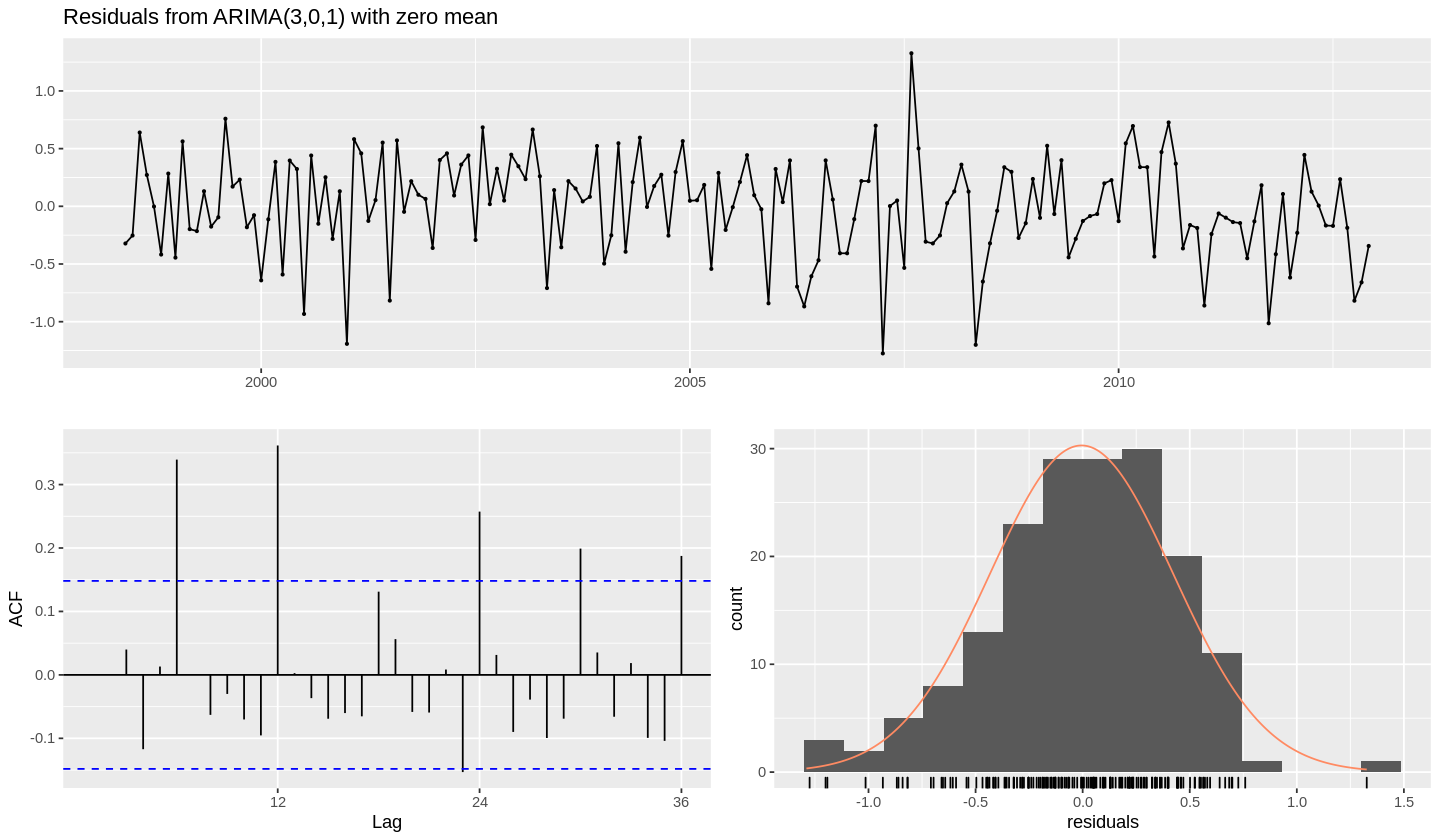


	Ljung-Box test

data:  Residuals from ARIMA(3,0,3) with zero mean
Q* = 52.31, df = 18, p-value = 0.00003352

Model df: 6.   Total lags used: 24



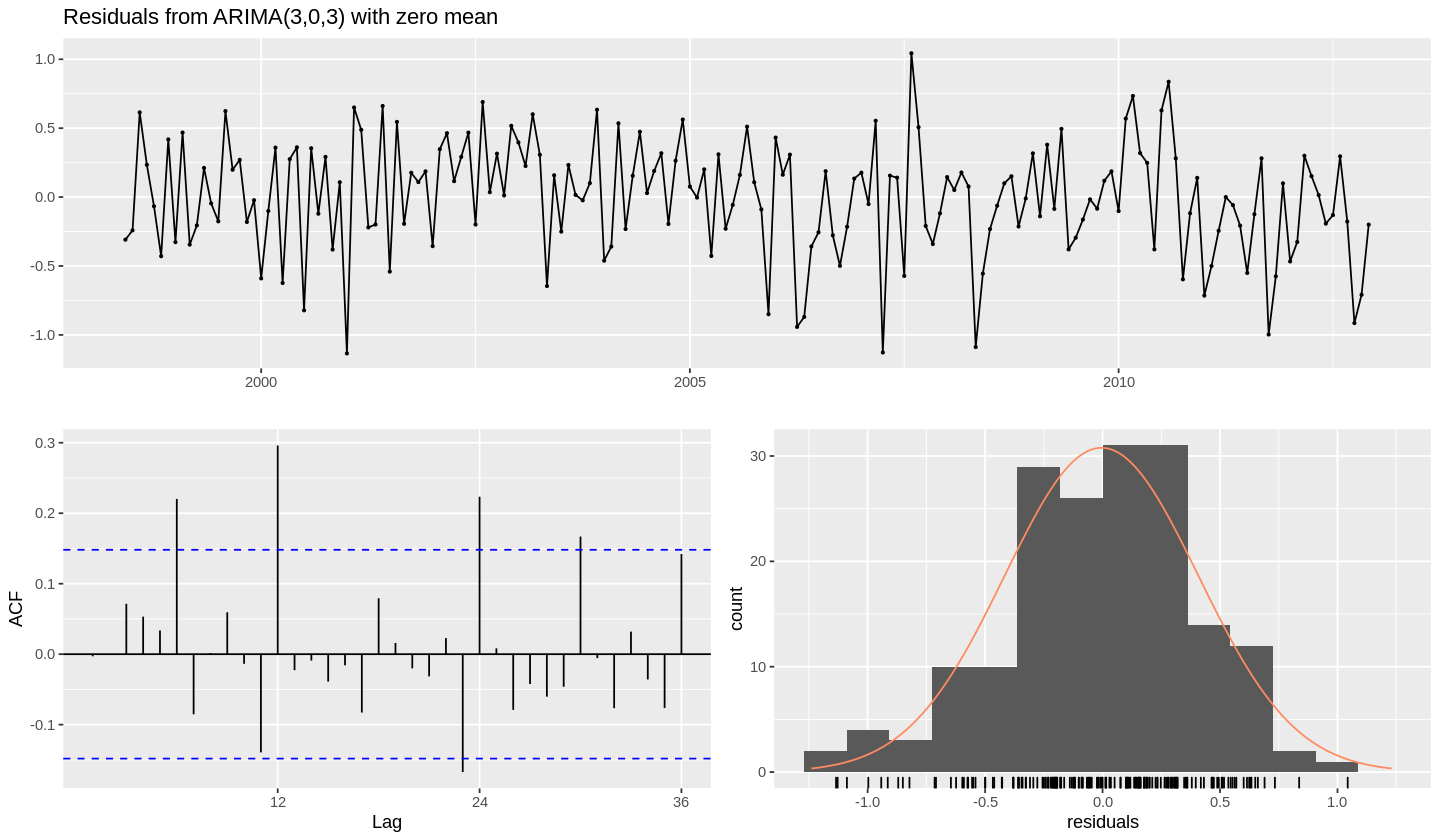


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with zero mean
Q* = 80.936, df = 23, p-value = 0.00000002239

Model df: 1.   Total lags used: 24



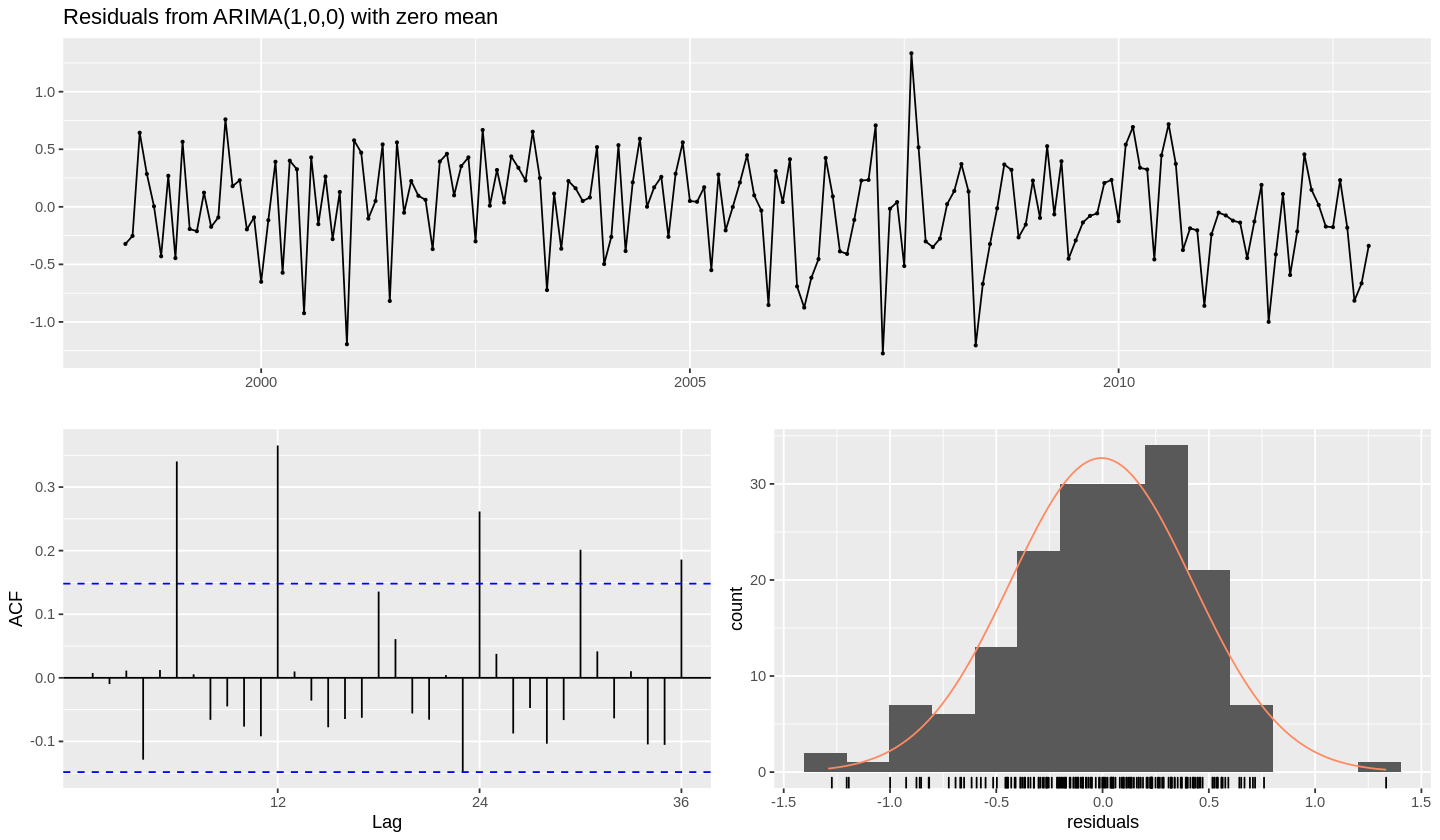

In [46]:
#Se chequean los residuos de los mejores ajustes
checkresiduals(fit_ARMA32_brasil_clean)
checkresiduals(fit_ARMA33_brasil_clean)
checkresiduals(fit_AR1_brasil_clean)

Los residuos de ARMA32 se parecen bastante ruido blanco, como lo podemos ver en las gráficas anteriores

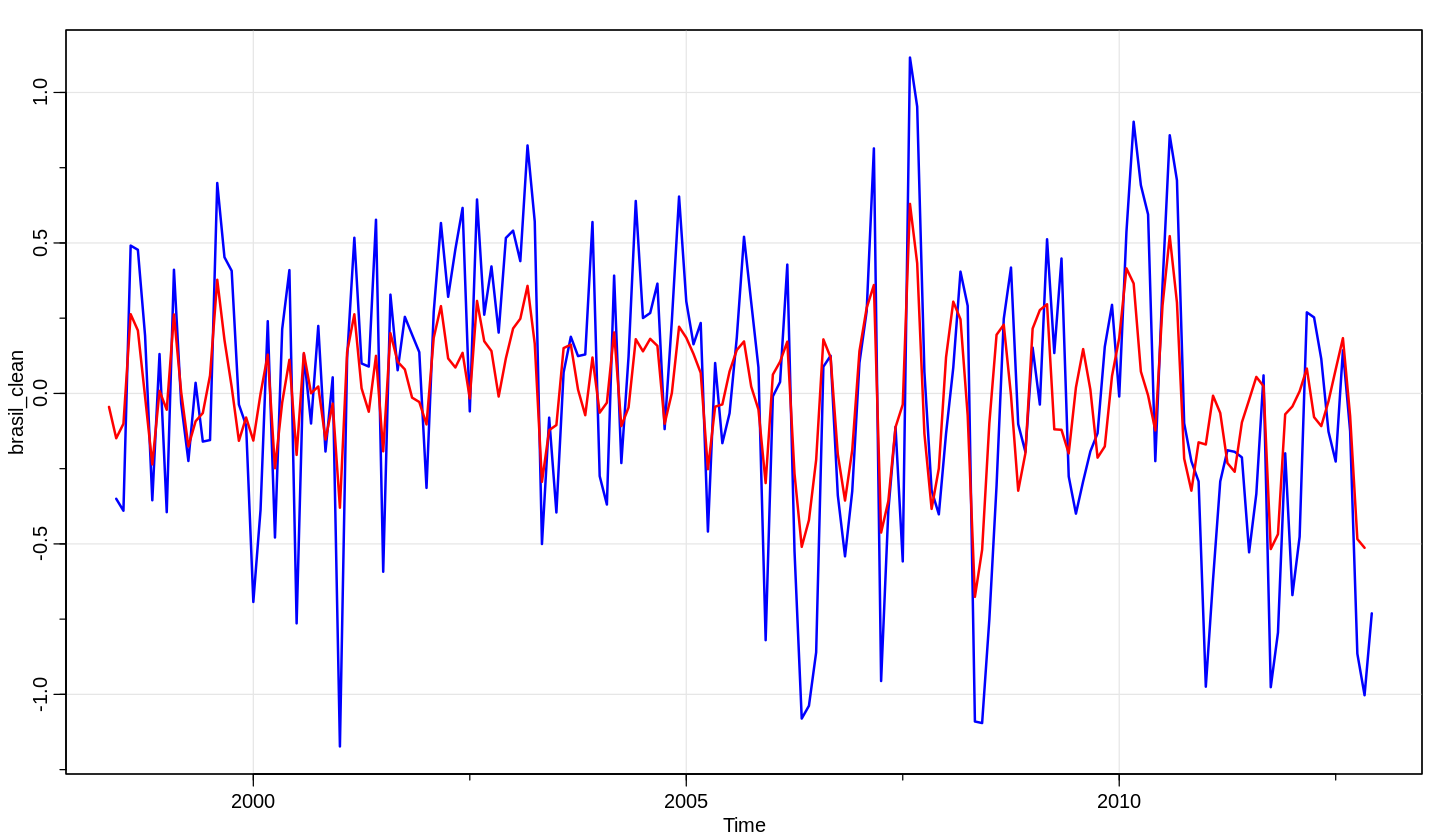

In [82]:
#Calculo las predicciones
pred_fit_ARMA31_brasil_clean = ts(fitted(fit_ARMA32_brasil_clean), start=1998+4/12, frequency=12)

#ploteamos
tsplot(brasil_clean, col=4, lwd=2)
lines(pred_fit_ARMA31_brasil_clean, col=2, lwd=2)

In [83]:
#Agregamos tiempos de 4 años para adelante mas los meses de 2013
t_forecast = seq(2013,2018-1/12,by=1/12)

#Lo convierto en serie temporal
t_forecast = ts(t_forecast,start=2013,freq=12)

forecast_preds = 0.68416*sin(2*pi*f1*t_forecast)+1.64666*cos(2*pi*f1*t_forecast)-0.32178*cos(2*pi*f2*t_forecast)+0.02187*t_forecast-35.14087

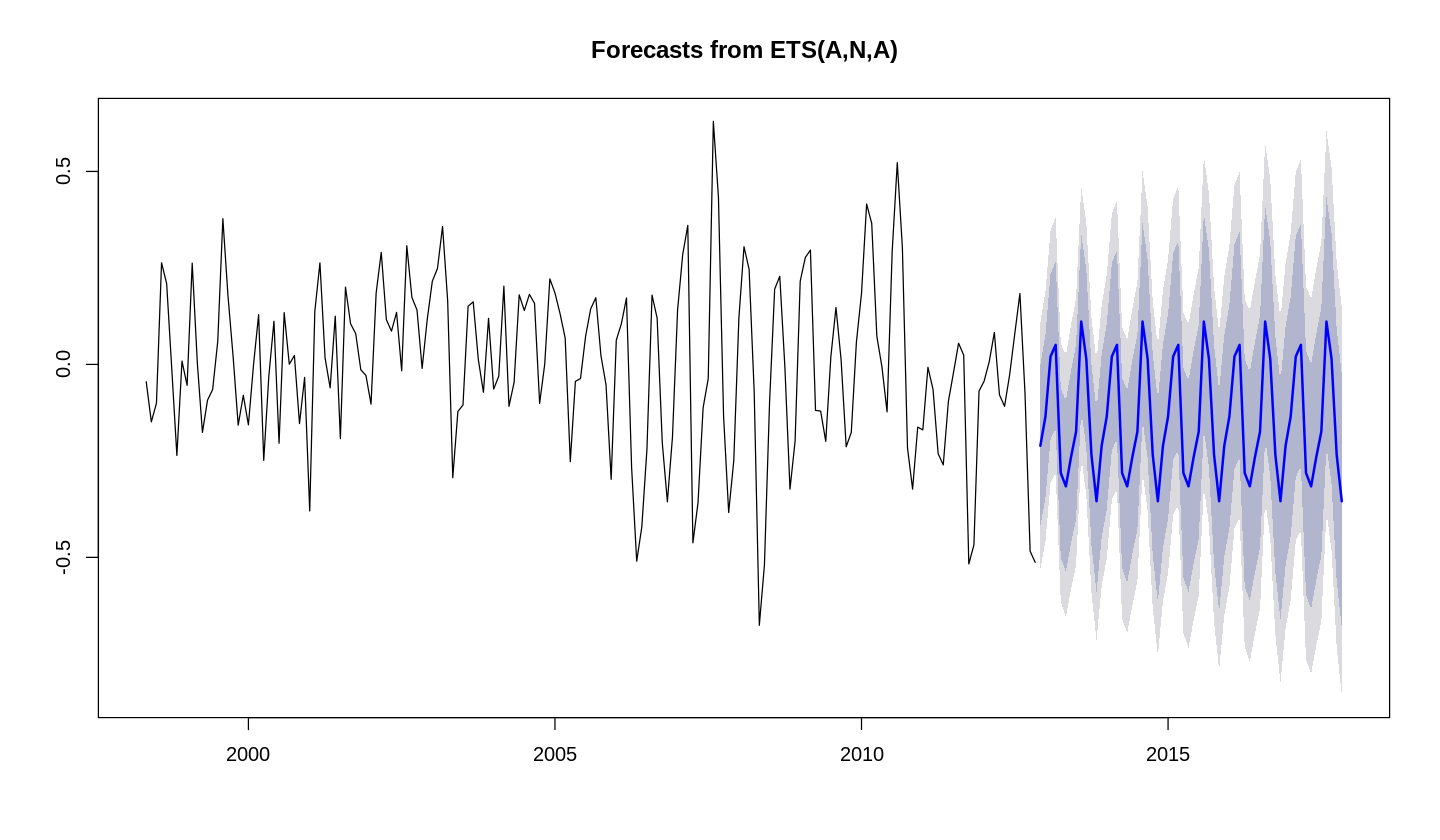

In [84]:
forecast_fit_ARMA31_brasil_clean = forecast(pred_fit_ARMA31_brasil_clean,h=60)
plot(forecast_fit_ARMA31_brasil_clean)

In [85]:
#Ahora vamos a regenerar la señal original para poder mostrar la predicción en la serie inicial

#Obtengo predicción de ARMA y banda alta y baja
prediccion_forecast_fit_ARMA31_brasil_clean_media = forecast_fit_ARMA31_brasil_clean$mean
prediccion_forecast_fit_ARMA31_brasil_clean_lower = forecast_fit_ARMA31_brasil_clean$lower[,2]   
prediccion_forecast_fit_ARMA31_brasil_clean_upper = forecast_fit_ARMA31_brasil_clean$upper[,2]

#Le agregamos las predicciones que calculamos yendo para atrás en los ajustes lineales
prediccion_forecast_fit_ARMA31_brasil_clean_media = forecast_preds + prediccion_forecast_fit_ARMA31_brasil_clean_media
prediccion_forecast_fit_ARMA31_brasil_clean_lower = forecast_preds + prediccion_forecast_fit_ARMA31_brasil_clean_lower
prediccion_forecast_fit_ARMA31_brasil_clean_upper = forecast_preds + prediccion_forecast_fit_ARMA31_brasil_clean_upper

#Desago el log
prediccion_forecast_fit_ARMA31_brasil_clean_media = exp(prediccion_forecast_fit_ARMA31_brasil_clean_media)
prediccion_forecast_fit_ARMA31_brasil_clean_lower = exp(prediccion_forecast_fit_ARMA31_brasil_clean_lower)
prediccion_forecast_fit_ARMA31_brasil_clean_upper = exp(prediccion_forecast_fit_ARMA31_brasil_clean_upper)

#Lo hago serie temmporal
prediccion_forecast_fit_ARMA31_brasil_clean_media = ts(prediccion_forecast_fit_ARMA31_brasil_clean_media, start=2013, frequency=12)
prediccion_forecast_fit_ARMA31_brasil_clean_lower = ts(prediccion_forecast_fit_ARMA31_brasil_clean_lower, start=2013, frequency=12)
prediccion_forecast_fit_ARMA31_brasil_clean_upper = ts(prediccion_forecast_fit_ARMA31_brasil_clean_upper, start=2013, frequency=12)

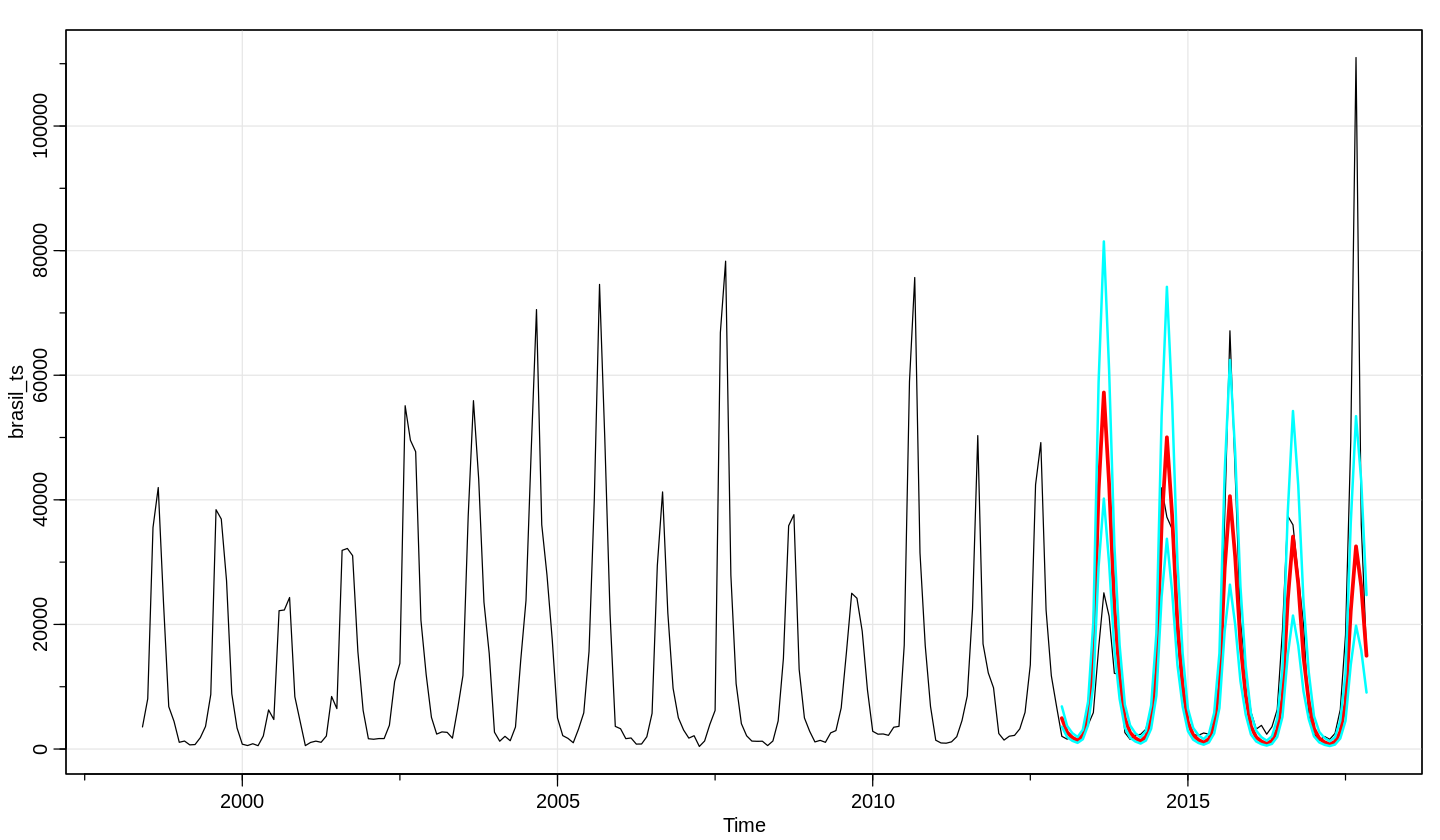

In [86]:
tsplot(brasil_ts, col=1, lwd=-1,xlim=c(1998,2018-1/12))
lines(prediccion_forecast_fit_ARMA31_brasil_clean_media,col=2,lwd=3)
lines(prediccion_forecast_fit_ARMA31_brasil_clean_lower,col=5,lwd=2)
lines(prediccion_forecast_fit_ARMA31_brasil_clean_upper,col=5,lwd=2)

Procederemos a ver si existe correlación con una serie temporal de otra variable, como se la temperatura en brasil para esos años

In [87]:
Brasil_Temp <- read_csv("Brasil_Temperature.csv")
Brasil_Temp = ts(Brasil_Temp$Temp, start=1998+5/12, frequency=12)
show(Brasil_Temp)

Parsed with column specification:
cols(
  Temp = col_double(),
  Year = col_double()
)



      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
1998                          23.9 24.5 25.3 25.7 26.3 26.0 26.1
1999 26.0 26.1 25.9 25.1 24.0 23.7 23.8 24.3 25.7 26.0 25.8 26.0
2000 25.9 25.7 25.5 25.3 24.6 24.0 22.9 24.8 25.2 26.5 25.9 25.8
2001 25.9 26.1 26.0 25.8 24.6 23.2 24.2 25.1 25.7 26.2 26.3 26.0
2002 26.0 26.0 26.3 26.0 25.2 24.0 24.2 25.2 25.5 27.0 26.4 26.3
2003 26.4 26.4 26.0 25.7 24.7 24.7 23.9 24.2 25.4 26.2 26.2 26.5
2004 26.1 25.8 26.0 26.0 24.4 23.9 23.6 24.6 26.2 26.4 26.4 26.2
2005 26.6 26.4 26.2 26.0 25.1 24.5 23.8 25.4 25.3 26.8 26.5 25.9
2006 26.5 26.2 26.1 25.4 24.1 23.9 24.3 25.0 25.5 26.6 26.1 26.4
2007 26.5 26.2 26.2 25.9 24.4 24.3 23.8 24.6 26.3 26.7 26.3 26.1
2008 25.6 25.8 25.6 25.3 24.1 23.4 24.2 25.2 25.6 26.7 26.3 26.0
2009 25.9 25.9 26.0 25.5 24.7 23.4 24.0 25.0 26.1 26.4 27.0 26.2
2010 26.5 27.0 26.6 25.8 24.9 23.7 24.1 24.7 26.5 26.5 26.1 26.3
2011 26.0 25.8 25.7 25.6 24.7 24.1 24.3 25.0 26.0 26.1 25.9 26.1
2012 25.7 25.9 25.8 25.7 

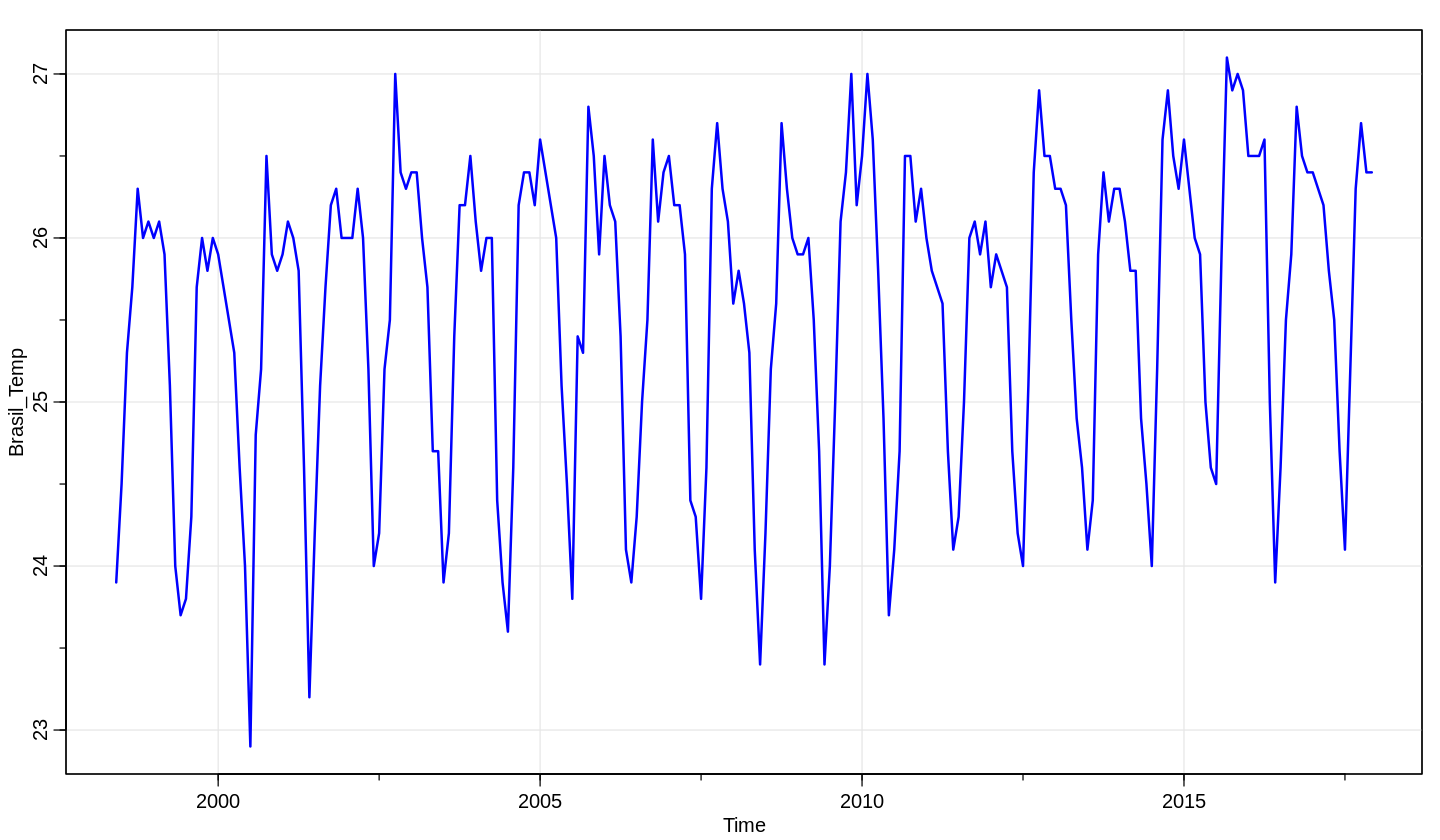

In [88]:
tsplot(Brasil_Temp, col=4, lwd=2)


Call:
lm(formula = Brasil_Temp ~ t)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4502 -0.7413  0.3452  0.6941  1.5841 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -33.05380   21.24081  -1.556  0.12103   
t             0.02919    0.01058   2.760  0.00624 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9166 on 233 degrees of freedom
Multiple R-squared:  0.03166,	Adjusted R-squared:  0.02751 
F-statistic: 7.618 on 1 and 233 DF,  p-value: 0.006237


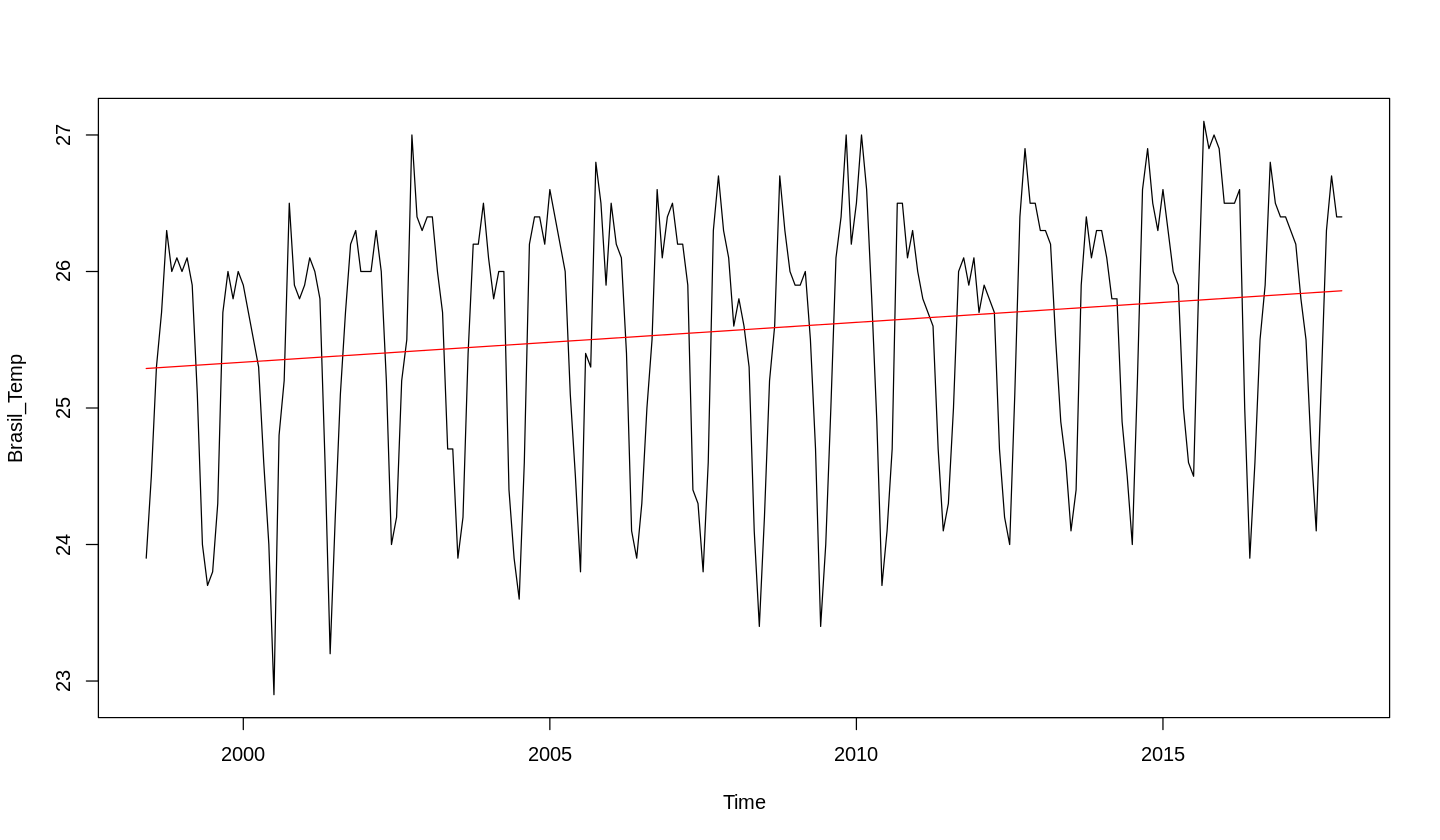

In [89]:
#Se hace ajuste por tendencia solamente
t = time(Brasil_Temp)
fit_lm1_Temp = lm(Brasil_Temp~t)
pred_fit_lm1_Temp = ts(predict(fit_lm1_Temp), start=c(1998, 6), frequency = 12)

#ploteamos señal y predicción
plot(Brasil_Temp)
lines(pred_fit_lm1_Temp, col=2)

summary(fit_lm1_Temp)

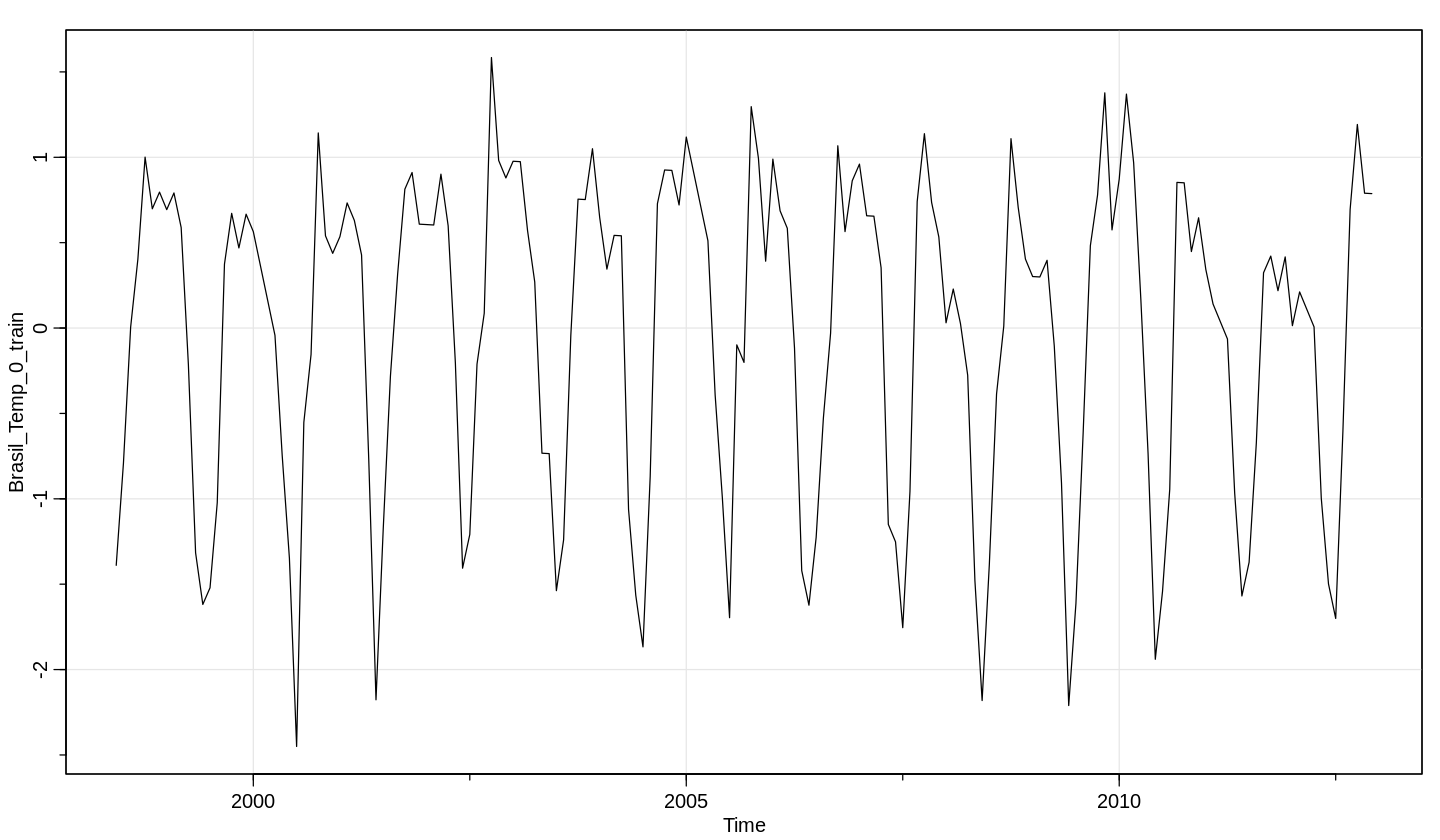

In [90]:
#Nuestra serie sin tendencia y centrada en 0 la obtenemos como los residuos del ajuste lineal anterior
Brasil_Temp_0 = ts(residuals(fit_lm1_Temp), start=c(1998, 6), frequency = 12)

#Separamos dataset en train y test
Brasil_Temp_0_train <- ts(Brasil_Temp_0[1:175], 
            start=c(1998, 6), 
            end=c(2012, 12),
            frequency = 12)
Brasil_Temp_0_test <- ts(Brasil_Temp_0[176:length(Brasil_Temp_0)], 
            start=c(2013, 1), 
            end=c(2017, 11),
            frequency = 12)
tsplot(Brasil_Temp_0_train)

In [91]:
season_Brasil_Temp =factor(cycle(Brasil_Temp_0_train))
t=time(Brasil_Temp_0_train)-1998 + 5/12
fit_Brasil_Temp_train_season = lm(Brasil_Temp_0_train ~ 0 + t + season_Brasil_Temp)

summary(fit_Brasil_Temp_train_season)


Call:
lm(formula = Brasil_Temp_0_train ~ 0 + t + season_Brasil_Temp)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98915 -0.25239  0.01097  0.21885  0.83138 

Coefficients:
                      Estimate Std. Error t value             Pr(>|t|)    
t                    -0.012359   0.005934  -2.083               0.0388 *  
season_Brasil_Temp1   0.715934   0.099986   7.160  0.00000000002662542 ***
season_Brasil_Temp2   0.693103   0.100219   6.916  0.00000000010199395 ***
season_Brasil_Temp3   0.591700   0.100454   5.890  0.00000002163360225 ***
season_Brasil_Temp4   0.247439   0.100691   2.457               0.0150 *  
season_Brasil_Temp5  -0.818249   0.100930  -8.107  0.00000000000012037 ***
season_Brasil_Temp6  -1.470282   0.097116 -15.139 < 0.0000000000000002 ***
season_Brasil_Temp7  -1.425018   0.097354 -14.638 < 0.0000000000000002 ***
season_Brasil_Temp8  -0.499755   0.097593  -5.121  0.00000085465508355 ***
season_Brasil_Temp9   0.405509   0.097835   4.145  0.00005468

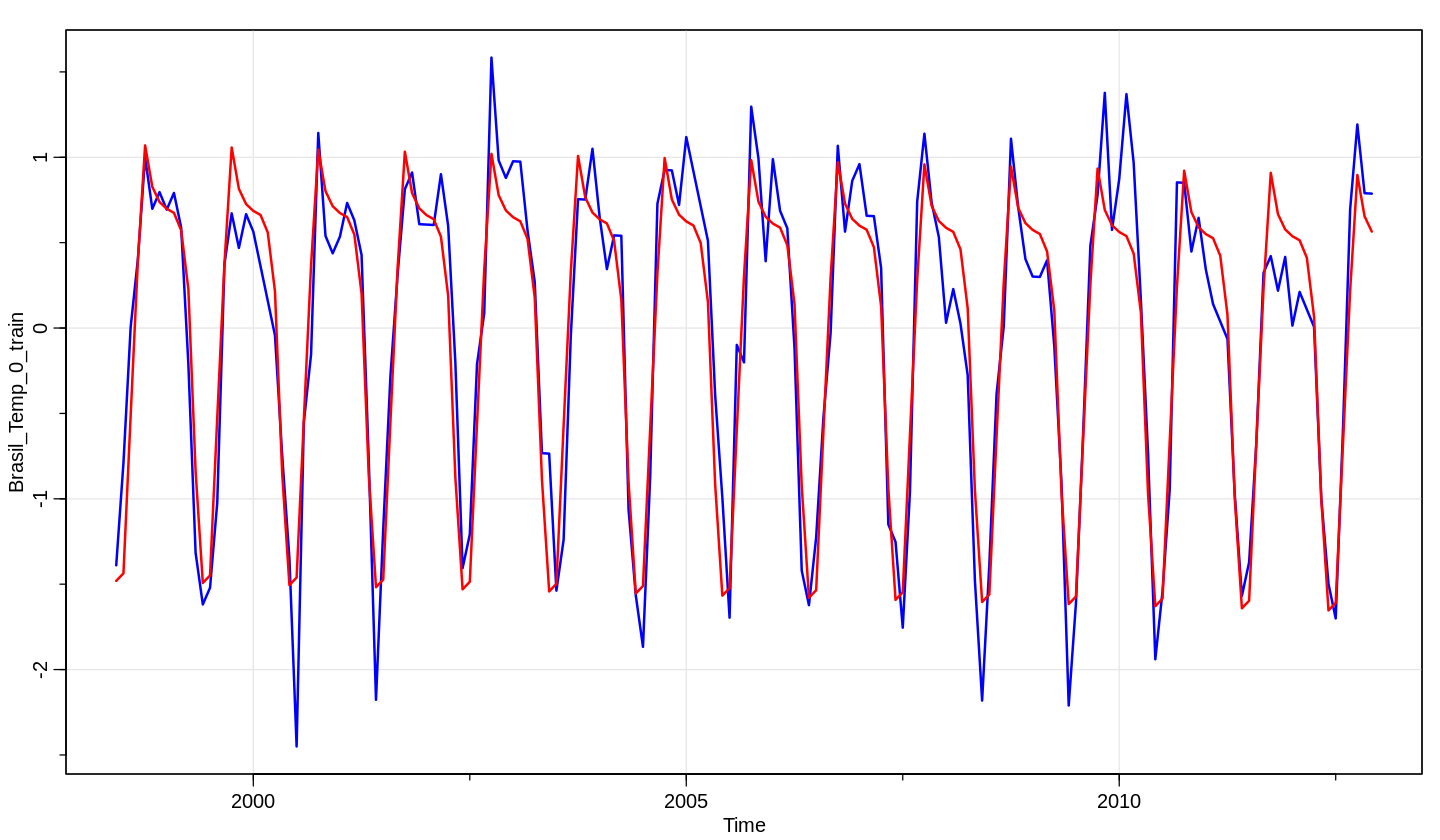

In [92]:
#Se muestra el ajuste mediante seasons
Brasil_Temp_train_season = ts(fitted(fit_Brasil_Temp_train_season), start=1998+5/12, frequency=12)
tsplot(Brasil_Temp_0_train, col=4, lwd=2)
lines(Brasil_Temp_train_season, col=2, lwd=2)

In [72]:
#De aqui en adelante por practicidad lo llamaremos brasil clean 
Brasil_Temp_clean= ts(residuals(fit_Brasil_Temp_train_season), start=1998+5/12, frequency=12)

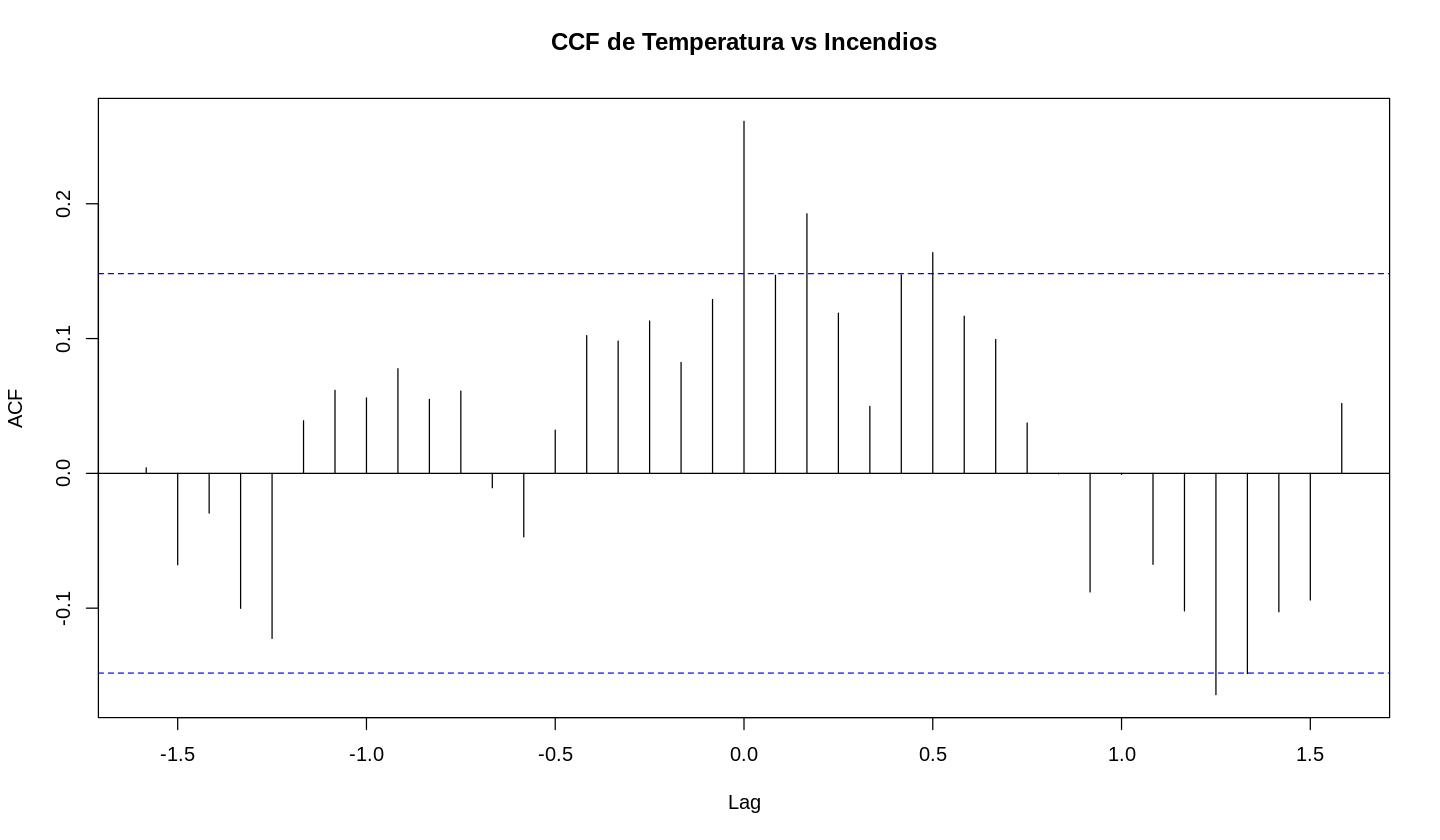

In [73]:
ccf(brasil_clean, Brasil_Temp_clean, main="CCF de Temperatura vs Incendios")

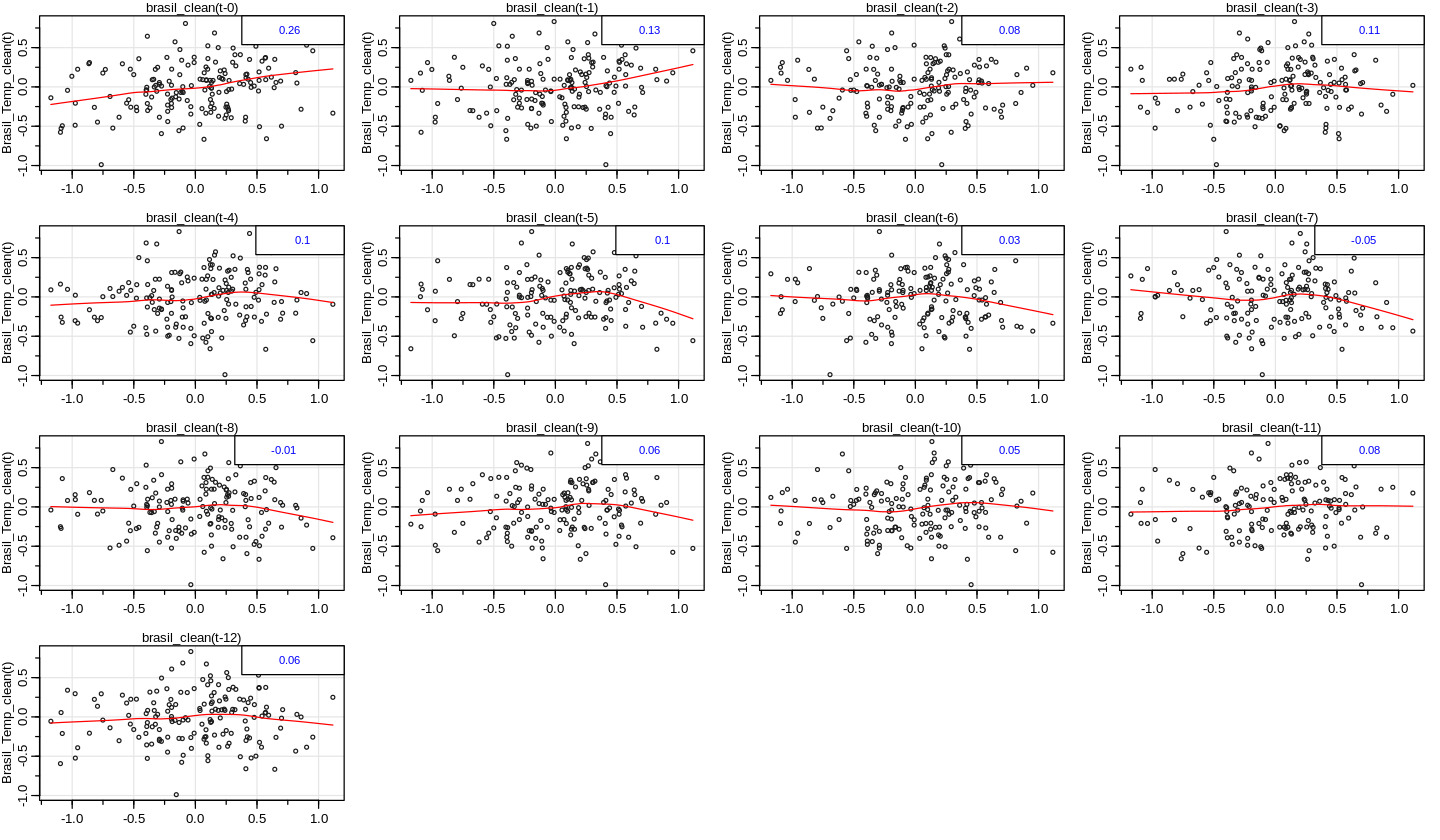

In [74]:
lag2.plot(brasil_clean, Brasil_Temp_clean, 12)

Al eliminar la componente estacional podemos ver en el ccf que parecería seguir habiendo cierta correlación positiva particularmente en 0 entre ambas.